In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scalarhadronizer import ScalarHadronizer
from particle import Particle as p
#using the hipsofcobra code to generate pi+pi- and K+K- decay widths, see https://arxiv.org/pdf/2407.13587
from hipsofcobra import HipsofCobra

# pi and K decay widths from literature

In [3]:
#hips_pi = HipsofCobra( clist=[1,1,1], Pname='pi', method='DGL')
#hips_pi.write_widths()
pi_data=np.loadtxt('/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/results/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_pi_method=DGL.csv',delimiter=',',skiprows=1)
m=pi_data[:,0]
gamma_pi_central=pi_data[:,1][m==2.0][0]
gamma_pi_lower=pi_data[:,2][m==2.0][0]
gamma_pi_upper=pi_data[:,3][m==2.0][0]
pi_width_2GeV=gamma_pi_central
print(pi_width_2GeV)

5.008185005808889e-08


In [4]:
#hips_K = HipsofCobra( clist=[1,1,1], Pname='K', method='DGL')
#hips_K.write_widths()
K_data=np.loadtxt('/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/results/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_K_method=DGL.csv',delimiter=',',skiprows=1)
m=K_data[:,0]
gamma_K_central=K_data[:,1][m==2.0][0]
gamma_K_lower=K_data[:,2][m==2.0][0]
gamma_K_upper=K_data[:,3][m==2.0][0]
K_width_2GeV=gamma_K_central

print(K_width_2GeV)

1.310270241863413e-07


In [5]:
#from own calculation of gluonic decay width
#hadronic_decay_width_2GeV=1.5294102825483557e-07

gamma_tot_central=1.5294102825483557e-07
gamma_tot_lower=8.402010413558565e-08
gamma_tot_upper=3.8896142800792654e-07
hadronic_decay_width_2GeV=gamma_tot_central
pi_branching_ratio=pi_width_2GeV/hadronic_decay_width_2GeV
print(f'Pi branching ratio: {pi_branching_ratio}')
K_branching_ratio=K_width_2GeV/hadronic_decay_width_2GeV
print(f'K branching ratio: {K_branching_ratio}')
print(f'Sum: {pi_branching_ratio+K_branching_ratio}')

Pi branching ratio: 0.3274585677208917
K branching ratio: 0.8567159883874953
Sum: 1.184174556108387


In [6]:
gamma_tot_NNLO_central=2.48023368e-07
gamma_tot_NNLO_lower=1.44417714e-07
gamma_tot_NNLO_upper=5.13730053e-07

In [7]:
gamma_K_central_last=K_data[-1,1]
gamma_K_lower_last=K_data[-1,2]
gamma_K_upper_last=K_data[-1,3]
gamma_pi_central_last=pi_data[-1,1]
gamma_pi_lower_last=pi_data[-1,2]
gamma_pi_upper_last=pi_data[-1,3]

In [7]:
print(gamma_pi_central-gamma_pi_lower,gamma_pi_central-gamma_pi_upper)

1.6994107378125742e-08 -2.0503547775092997e-08


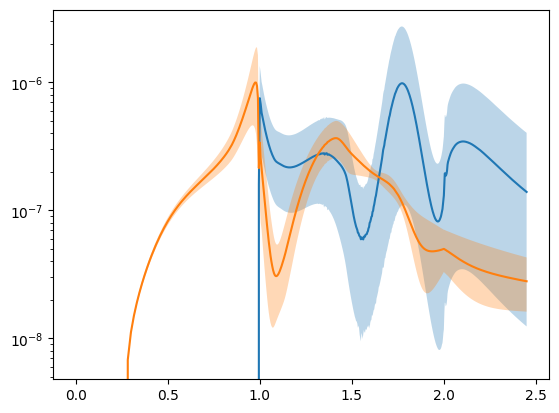

In [8]:
plt.plot(K_data[:,0],K_data[:,1])
plt.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)
plt.plot(pi_data[:,0],pi_data[:,1])
plt.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
plt.yscale('log')

# Ratio of down and strange weight from data
$\Gamma_\pi/\Gamma_K = \frac{2p(\pi)w_d}{3p(K)w_s}$
so $w_d/w_s$ is:

In [5]:
def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K=p.findall('K+')[0]
pi=p.findall('pi0')[0]
K.mass
print(3*p_restframe(2000,K.mass,K.mass)*pi_width_2GeV/(2*p_restframe(2000,pi.mass,pi.mass)*K_width_2GeV))

0.503205697784993


# Fit parameters

In [6]:
def fit_parameters():
    SH=ScalarHadronizer(2000)
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    up_weights=np.linspace(1,50,10)
    OAM_supression_pars=[2,1,0.5,0.2,0.1]
    for OAM_supression_par in OAM_supression_pars:
        for up_weight in up_weights:
            down_weights=np.arange(1,up_weight,1)
            strange_weights=2*down_weights
            for down_weight,strange_weight in zip(down_weights,strange_weights):
                SH.set_parameters(OAM_supression_par,up_weight,down_weight,strange_weight,charm_weight=1,bottom_weight=1)
                meson_pairs={}
                total_weight=0
                for i,m1 in enumerate(mesons_below_threshold):
                    for m2 in mesons_below_threshold[i:]:
                        if SH.check_meson_combinations(m1,m2,2000):
                            weight=SH.initialWeight(m1,m2)
                            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
                            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
                            total_weight+=weight
                    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
                init_pairs=SH.make_initialMesonPairs()
                if (-211,211) in init_pairs or (211,-211) in init_pairs:
                    pi_fit=init_pairs[(-211,211)]
                if (-321,321) in init_pairs or (321,-321) in init_pairs:
                    K_fit=init_pairs[(-321,321)]

                print('------------------------------------')
                print(f'pi_fit: {pi_fit}, K_fit: {K_fit}')
                print(f'Ratio: {pi_fit/K_fit}')
                print(f'up_weight: {up_weight}, down_weight: {down_weight}, strange_weight: {strange_weight}, OAM_supression_par: {OAM_supression_par}')
                err_pi=np.abs(1-pi_fit/pi_branching_ratio)
                err_K=np.abs(1-K_fit/K_branching_ratio)
                print(f'Error pi: {err_pi}, Error K: {err_K}')
                print(f'------------------------------------')
                print('\n')
                if err_pi<5e-2 and err_K<5e-2:
                    return up_weight,down_weight,strange_weight,OAM_supression_par
    return None

up_weight_fit,down_weight_fit,strange_weight_fit,OAM_supression_par_fit=fit_parameters()

------------------------------------
pi_fit: 0.03409139777804529, K_fit: 0.09072872151898563
Ratio: 0.3757508891041898
up_weight: 6.444444444444445, down_weight: 1.0, strange_weight: 2.0, OAM_supression_par: 2
Error pi: 0.7352286557474519, Error K: 0.7306664537143865
------------------------------------


------------------------------------
pi_fit: 0.046233184139089174, K_fit: 0.12304211508138156
Ratio: 0.3757508891041899
up_weight: 6.444444444444445, down_weight: 2.0, strange_weight: 4.0, OAM_supression_par: 2
Error pi: 0.6409292926831671, Error K: 0.6347422443242914
------------------------------------


------------------------------------
pi_fit: 0.050486566531336874, K_fit: 0.13436180191535818
Ratio: 0.37575088910418986
up_weight: 6.444444444444445, down_weight: 3.0, strange_weight: 6.0, OAM_supression_par: 2
Error pi: 0.6078953355263622, Error K: 0.6011390881594654
------------------------------------


------------------------------------
pi_fit: 0.05146580730330256, K_fit: 0.1

# Scalar resonances?

In [94]:
scalar_resonances=p.findall(lambda p: p.J==0 and p.C==1 and p.P==1)# and p.I==0)
for s in scalar_resonances:
    print(s.name,s.mass,s.J)
    dec=SH.single_particle_decays(s.pdgid)
    if (-211,211) in dec:
        print(f'\t pi+pi- br: {dec[(-211,211)]}')
    if (211,-211) in dec:
        print(f'\t pi+pi- br: {dec[(211,-211)]}')

    if (-321,321) in dec:
        print(f'\t K+K- br: {dec[(-321,321)]}')
    if (321,-321) in dec:
        print(f'\t K+K- br: {dec[(321,-321)]}')


a(0)(1450)0 1439.0 0.0
f(0)(1370) 1350.0 0.0
	 pi+pi- br: 0.5200000000000001
	 K+K- br: 0.03500000000000001
f(0)(1710) 1733.0 0.0
chi(c0)(1P) 3414.71 0.0
chi(b0)(1P) 9859.4 0.0
chi(b0)(2P) 10232.5 0.0
a(0)(980)0 980.0 0.0
	 K+K- br: 0.05
f(0)(500) 600.0 0.0
f(0)(980) 990.0 0.0
	 pi+pi- br: 0.6667
f(0)(1500) 1522.0 0.0
	 pi+pi- br: 0.23300000000000004
	 K+K- br: 0.043000000000000003
f(0)(2020) 1982.0 0.0


Since the widths of f(1370) and f(1500) are not very big (from pdg) they shouldnt affect the pi+pi- or K+K- brs too much, so its probably unnecessary to implement resonances in the model. Note: pdg doesn't list the branching ratios above for f(1370)

# Plot branching ratios

In [7]:
SH=ScalarHadronizer(2000,up_weight=up_weight_fit,down_weight=down_weight_fit,strange_weight=strange_weight_fit,OAM_supression_par=OAM_supression_par_fit) 
decay_graph=SH.simulateDecay()
print('\n')
SH.print_initial_states()
SH.print_final_states(10,decay_graph)

Building decay graph...
Generated 22 initial meson pairs.
Generated decay graph with 254 nodes and 383 edges.
Building weights...
254 of 254 nodes done

Done


The following initial states were generated:
K- K+: 0.32835002343059816
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K(0)*(700)- K(0)*(700)+: 0.20191050321199439
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
pi- pi+: 0.12337781324142882
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: -1 -1
K~0 K0: 0.05836675917488185
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
eta eta: 0.05264355994275247
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
eta eta'(958): 0.04054143281907074
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.03598405007738514
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
K*(892)- K*(892)+: 0.03418392541815803
	 J: 1.0 1.0, I: 0.5 0.5, C: 5 5, P: -1 -1
a(0)(980)- a(0)(980)+: 0.024794560221920704
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: 1 1
eta eta(1295): 0.022754048830717126
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
rho(770)- rho

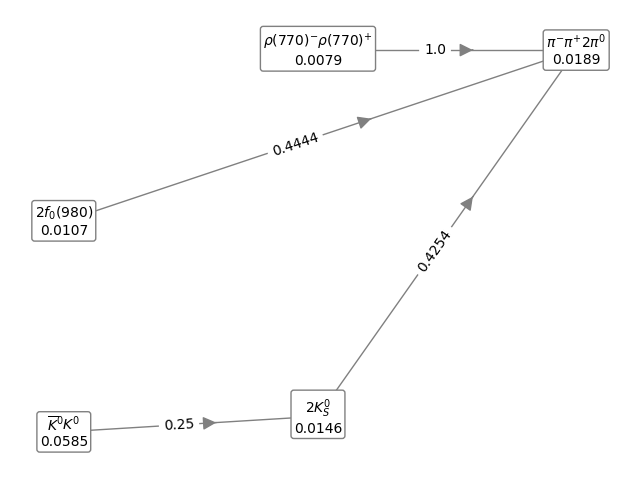

In [140]:
SH.plot_from_final_state(decay_graph,(-211,111,111,211))

In [8]:
masses=np.linspace(2000,5000,15)
pi_br=np.zeros(len(masses))
K_br=np.zeros(len(masses))
four_pi1=np.zeros(len(masses))
four_pi2=np.zeros(len(masses))
most_common_br=np.zeros((10,len(masses)))
brs=[]
for i,m in enumerate(masses):
    SH=ScalarHadronizer(m,up_weight=up_weight_fit,down_weight=down_weight_fit,strange_weight=strange_weight_fit,OAM_supression_par=OAM_supression_par_fit) 
    decay_graph=SH.simulateDecay()
    final_states=SH.get_most_common_final_states(decay_graph)
    brs.append(final_states)


Building decay graph...
Generated 22 initial meson pairs.
Generated decay graph with 254 nodes and 383 edges.
Building weights...
254 of 254 nodes done

Done
Building decay graph...
Generated 28 initial meson pairs.
Generated decay graph with 347 nodes and 564 edges.
Building weights...
347 of 347 nodes done

Done
Building decay graph...
Generated 37 initial meson pairs.
Generated decay graph with 467 nodes and 815 edges.
Building weights...
467 of 467 nodes done

Done
Building decay graph...
Generated 60 initial meson pairs.
Generated decay graph with 918 nodes and 1939 edges.
Building weights...
918 of 918 nodes done

Done
Building decay graph...
Generated 80 initial meson pairs.
Generated decay graph with 1172 nodes and 2638 edges.
Building weights...
1172 of 1172 nodes done

Done
Building decay graph...
Generated 100 initial meson pairs.
Generated decay graph with 1334 nodes and 3037 edges.
Building weights...
1334 of 1334 nodes done

Done
Building decay graph...
Generated 113 init

In [13]:
pi_br=[f[(-211,211)] for f in brs if (-211,211) in f]
K_br=[f[(-321,321)] for f in brs if (-321,321) in f]
four_pi1=[f[(-211,111,111,211)] for f in brs if (-211,111,111,211) in f]

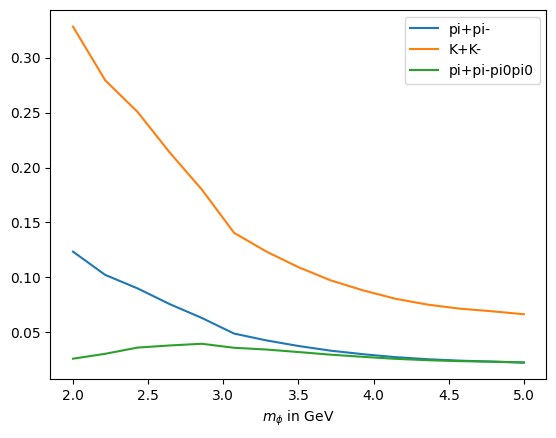

In [14]:
plt.plot(masses*1e-3,pi_br,label='pi+pi-')
plt.plot(masses*1e-3,K_br,label='K+K-')
plt.plot(masses*1e-3,four_pi1,label='pi+pi-pi0pi0')
#plt.plot(masses*1e-3,four_pi2,label='4pi0')
plt.xlabel(r'$m_\phi$ in GeV')
plt.legend()

In [26]:
from particle import Particle as p
k=p.findall('K+')[0]
pi=p.findall('pi0')[0]
k.pdgid.has_strange
pi.pdgid.has_down
eta=p.findall('eta')[0]
eta.quarks

'x(uU+dD)+y(sS)'

In [110]:
SH=ScalarHadronizer(2000,OAM_supression_par=1,up_weight=1,down_weight=1,strange_weight=1)
SH.print_initial_states()

The following initial states were generated:
eta eta: 0.10566557281557871
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
eta eta'(958): 0.0813743167492831
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
omega(782) omega(782): 0.0786205321854996
	 J: 1.0 1.0, I: 0.0 0.0, C: -1 -1, P: -1 -1
K- K+: 0.054921712088386546
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K~0 K0: 0.054779928858596616
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
omega(782) phi(1020): 0.05439375698747177
	 J: 1.0 1.0, I: 0.0 0.0, C: -1 -1, P: -1 -1
eta f(1)(1285): 0.04744928898270968
	 J: 0.0 1.0, I: 0.0 0.0, C: 1 1, P: -1 1
eta eta(1295): 0.0456716758172503
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
pi0 pi0: 0.04130029918301476
	 J: 0.0 0.0, I: 1.0 1.0, C: 1 1, P: -1 -1
pi- pi+: 0.04127376429667116
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: -1 -1
eta'(958) eta'(958): 0.03631390443252116
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.033772711234096475
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
K(0)*(700)- K(0)*(

In [89]:
up_weigth=28
down_weight=5
strange_weight=2*down_weight
OAM_supression_par=0.1
SH=ScalarHadronizer(2000,OAM_supression_par=OAM_supression_par,up_weight=up_weigth,down_weight=down_weight,strange_weight=strange_weight)

initial_states=SH.make_initialMesonPairs()
print('The following initial states were generated:')
sorted_states = dict(sorted(initial_states.items(), key=lambda item: item[1], reverse=True))
for key, value in sorted_states.items():
    p1=p.from_pdgid(key[0])
    p2=p.from_pdgid(key[1])
    print(f'{p1.name} {p2.name}: {value}')
    print(f'\t J: {p1.J} {p2.J}, I: {p1.I} {p2.I}, C: {p1.C} {p2.C}, P: {p1.P} {p2.P}')

gamma_pi=initial_states[(-211,211)]
gamma_K=initial_states[(-321,321)]
print('\n')
print(f'Simulated pi+pi- branching ratio: {gamma_pi}, calculated branching ratio: {pi_width_2GeV/hadronic_decay_width_2GeV}')
print(f'Simulated K+K- branching ratio: {gamma_K}, calculated branching ratio: {K_width_2GeV/hadronic_decay_width_2GeV}')
print(f'Ratio: {gamma_pi/gamma_K}')

<PDGID: 211> <PDGID: -211>
990.2121521347068 140 1 0.33
28 5 10
<PDGID: 321> <PDGID: -321>
869.6453413150674 280 1 0.5
28 5 10
The following initial states were generated:
K- K+: 0.33065648331760195
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K(0)*(700)- K(0)*(700)+: 0.20332880211009588
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
pi- pi+: 0.12424446759465367
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: -1 -1
eta eta: 0.06361601885008838
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K~0 K0: 0.058893370815657695
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
eta eta'(958): 0.048991454172784575
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.03630871466251712
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
eta eta(1295): 0.0274966586778107
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
a(0)(980)- a(0)(980)+: 0.02496872697839072
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: 1 1
K*(892)- K*(892)+: 0.01721202338690927
	 J: 1.0 1.0, I: 0.5 0.5, C: 5 5, P: -1 -1
eta eta(1405): 0.01422781298196137
	 J: 0.0 0.0

In [68]:
pi_width_2GeV/K_width_2GeV

np.float64(0.3822253490765731)

In [15]:
import pdg
api = pdg.connect()
eta=api.get_particle_by_mcid(221)

In [23]:
eta.width

1.3076917231244102e-06

In [31]:
SH.single_particle_decays(10331)

{}

up/down weight sollten gleich sein (isospin). Quark mixtures betrachten (srangeness anteil, v.a. eta). Siehe auch herwig manual. eta eta' wie herwig, omega ohne strange, phi nur strange

In [24]:
p.findall('h(1)')

[<Particle: name="h(1)(1170)", pdgid=10223, mass=1166 ± 6 MeV>,
 <Particle: name="h(1)(1415)", pdgid=10333, mass=1409 + 9 - 8 MeV>]

In [12]:
SH=ScalarHadronizer(2000)
SH.neutral_light_meson_mixing()

{111: [0.5, 0.5, 0, 0, 0],
 221: [np.float64(0.42366459261474937),
  np.float64(0.42366459261474937),
  np.float64(0.15267081477050132),
  0,
  0],
 331: [np.float64(0.07633540738525066),
  np.float64(0.07633540738525066),
  np.float64(0.8473291852294987),
  0,
  0],
 333: [np.float64(0.42366459261474937),
  np.float64(0.42366459261474937),
  np.float64(0.15267081477050132),
  0,
  0],
 223: [np.float64(0.07633540738525066),
  np.float64(0.07633540738525066),
  np.float64(0.8473291852294987),
  0,
  0]}

In [9]:
0.5*np.cos(np.arctan(1/np.sqrt(2)))**2

np.float64(0.3333333333333333)

Identify singlets and octets to assign mixing angles

In [27]:
p.findall(lambda p: p.J==0 and p.P==-1 and p.invert()==p and p.L==0)

[<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
 <Particle: name="K(L)0", pdgid=130, mass=497.611 ± 0.013 MeV>,
 <Particle: name="eta", pdgid=221, mass=547.862 ± 0.017 MeV>,
 <Particle: name="K(S)0", pdgid=310, mass=497.611 ± 0.013 MeV>,
 <Particle: name="eta'(958)", pdgid=331, mass=957.78 ± 0.06 MeV>,
 <Particle: name="eta(c)(1S)", pdgid=441, mass=2984.1 ± 0.4 MeV>,
 <Particle: name="eta(b)(1S)", pdgid=551, mass=9398.7 ± 2.0 MeV>,
 <Particle: name="pi(1300)0", pdgid=100111, mass=1300 ± 100 MeV>,
 <Particle: name="eta(1295)", pdgid=100221, mass=1294 ± 4 MeV>,
 <Particle: name="eta(1475)", pdgid=100331, mass=1476 ± 4 MeV>,
 <Particle: name="eta(c)(2S)", pdgid=100441, mass=3637.7 ± 0.9 MeV>]

In [42]:
SH=ScalarHadronizer(2000)
decay_graph=SH.simulateDecay()
SH.print_final_states(10,decay_graph)

Building decay graph...
Generated 21 initial meson pairs.
Generated decay graph with 193 nodes and 314 edges.
Building weights...
193 of 193 nodes done

Done
The following final states were generated:
(-211, -211, 111, 111, 211, 211) pi- pi- pi0 pi0 pi+ pi+ :  0.16796008925627406
(-211, 111, 111, 211) pi- pi0 pi0 pi+ :  0.05502637882547542
(22, 22, 111, 111, 111) gamma gamma pi0 pi0 pi0 :  0.04479711486709805
(-321, -211, 111, 211, 321) K- pi- pi0 pi+ K+ :  0.04028964812156559
(-211, -211, 211, 211) pi- pi- pi+ pi+ :  0.03429098592946386
(111, 111) pi0 pi0 :  0.0335855840458642
(-211, 211) pi- pi+ :  0.03356400576015999
(-211, 22, 22, 111, 111, 111, 211) pi- gamma gamma pi0 pi0 pi0 pi+ :  0.03179387089981463
(-211, 22, 22, 111, 211) pi- gamma gamma pi0 pi+ :  0.03127683119673963
(22, 22, 100221) gamma gamma eta(1295) :  0.029429336538021635


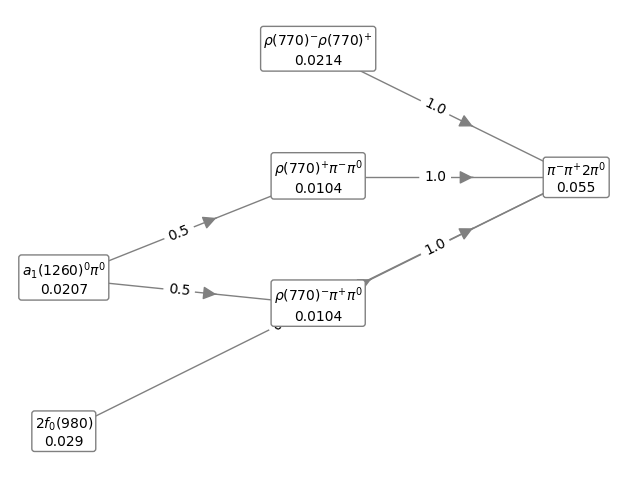

In [43]:
SH.plot_from_final_state(decay_graph,(-211,111,111,211))

In [36]:
import networkx as nx
state=(-211,111,111,211)
ancestors=nx.ancestors(decay_graph,state)
connected_initial_states=[k for k in ancestors if decay_graph.in_degree()[k]==0]

In [37]:
connected_initial_states

[(-213, 213), (111, 20113), (9010221, 9010221)]

In [40]:
def make_weight(decay_graph,state,weight=0):
    in_edges=decay_graph.in_edges(state,'weight')
    if in_edges:
        for edge in in_edges:
            weight+=make_weight(decay_graph,edge[0])*edge[2]
    else:
        weight=decay_graph.nodes[state]['weight']
    return weight

make_weight(decay_graph,(-211,111,111,211))


np.float64(0.05502637882547542)

In [52]:
def weight_for_opti(decay_graph,state,up_weight,down_weight,strange_weight,OAM_supression_par,weight=0):
    in_edges=decay_graph.in_edges(state,'weight')
    if in_edges:
        for edge in in_edges:
            weight+=weight_for_opti(decay_graph,edge[0],up_weight,down_weight,strange_weight,OAM_supression_par,weight)*edge[2]
    else:
        m1=p.from_pdgid(state[0])
        m2=p.from_pdgid(state[1])
        weight=SH.initialWeight(m1,m2,up_weight,down_weight,strange_weight,0,0,OAM_supression_par)
    return weight


In [6]:
SH=ScalarHadronizer(2000,1,1,1,1,1,1)
decay_graph=SH.simulateDecay()
final_states=SH.get_most_common_final_states(decay_graph)
for k,v in final_states.items():
    print(k,v,weight_for_opti(decay_graph,k,1,1,1,1))

Building decay graph...
Generated 28 initial meson pairs.
Generated decay graph with 266 nodes and 418 edges.
Building weights...
266 of 266 nodes done

Done


NameError: name 'weight_for_opti' is not defined

# Fit model to data

In [7]:
import scipy.optimize as optimize
SH1=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(gamma_pi,gamma_K,spin_supression):
    ws=strange_weight(gamma_pi,gamma_K)
    pairs=update_init_weights(SH1,meson_pairs,ws,spin_supression)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


def print_result(res,spin_sup=None):
    if len(res.fun)>2:
        print(f'Gamma_pi: {res.x[0]}, rel. dist. to central value: {res.fun[2]}')
        print(f'Gamma_K: {res.x[1]}, rel. dist. to central value: {res.fun[3]}')
    if len(res.fun)>4: print(f'Gamma_tot: {res.x[2]}, rel. dist. to central value: {res.fun[4]}')
    print(f'Cost: {res.cost}')
    print('Parameters:')
    sw=strange_weight(res.x[0],res.x[1])
    print(f'\t strange_weight = {sw}')
    if spin_sup is None: spin_sup=res.x[3]
    print(f'\t spin_supression = {spin_sup}')
    SH=ScalarHadronizer(2000,OAM_supression_par=spin_sup,up_weight=1,down_weight=1,strange_weight=sw)
    pairs=SH.make_initialMesonPairs()
    print('Branching ratios:')
    print(f'\t K+K-: {pairs[(-321,321)]}')
    print(f'\t K0K~0-: {pairs[(-311,311)]}')
    print(f'\t pi+pi-: {pairs[(-211,211)]}')
    print(f'\t pi0pi0: {pairs[(111,111)]}')
    #SH.print_initial_states()
    print(f'Check: ')
    BR_K=pairs[(-321,321)]+pairs[(-311,311)]
    BR_pi=pairs[(-211,211)]+pairs[(111,111)]
    print(f'\t Gamma_pi/Gamma_K: {res.x[0]/res.x[1]}, BR(pi)/BR(K): {BR_pi/BR_K}')
    print(f'\t BR(K)*gamma_tot: {BR_K*res.x[2]}, Gamma_K: {res.x[1]}, error: {abs(1-BR_K*res.x[2]/res.x[1])}')
    print(f'\t BR(pi)*gamma_tot: {BR_pi*res.x[2]}, Gamma_pi: {res.x[0]}, error: {abs(1-BR_pi*res.x[2]/res.x[0])}')
    print('\n')
    SH.print_initial_states()

In [106]:
#NLO, fixed spin supression
spin_sup=0.01
def f(x,OAM_supression_par):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,OAM_supression_par)
    #return np.array([br_pi-gamma_pi/gamma_tot, br_K-gamma_K/gamma_tot,1-gamma_pi/gamma_pi_central,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_central])
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central/1.2,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_central])
    #return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central/1.2,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_NNLO_central])
res=optimize.least_squares(f,[gamma_pi_central,gamma_K_central,gamma_tot_central],args=(spin_sup,),bounds=([gamma_pi_lower,gamma_K_lower,gamma_tot_lower],[gamma_pi_upper,gamma_K_upper,gamma_tot_upper]))
print(res)
print('\n')
print_result(res,spin_sup)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.947e-01 -1.827e-01  2.980e-01  6.092e-01 -3.175e-01]
           x: [ 4.219e-08  5.121e-08  2.015e-07]
        cost: 0.3160163680721204
         jac: [[-1.349e+07 -1.261e+07  5.521e+06]
               [-1.336e+07 -1.248e+07  5.465e+06]
               ...
               [ 0.000e+00 -7.632e+06  0.000e+00]
               [ 0.000e+00  0.000e+00 -6.538e+06]]
        grad: [ 1.086e+05  8.505e+04  2.729e+03]
  optimality: 0.0033525472598196723
 active_mask: [-1  0  0]
        nfev: 16
        njev: 13


Gamma_pi: 4.2186560528663264e-08, rel. dist. to central value: 0.2980397675716193
Gamma_K: 5.1209167575960734e-08, rel. dist. to central value: 0.60917094855842
Gamma_tot: 2.015043365602708e-07, rel. dist. to central value: -0.31752963125445577
Cost: 0.3160163680721204
Parameters:
	 strange_weight = 0.6921236302169848
	 spin_supression = 0.01
Branching ratios:
	 K+K-: 0.1242358375164840

In [113]:
#NNLO
import scipy.optimize as optimize
spin_sup=0.1
def f(x,OAM_supression_par):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,OAM_supression_par)
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central/1.2,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_NNLO_central])
res=optimize.least_squares(f,[gamma_pi_central,gamma_K_central,gamma_tot_NNLO_central],args=(spin_sup,),bounds=([gamma_pi_lower,gamma_K_lower,gamma_tot_NNLO_lower],[gamma_pi_upper,gamma_K_upper,gamma_tot_NNLO_upper]))
print(res)
print('\n')
print_result(res,spin_sup)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.824e-01 -1.705e-01  2.096e-01  5.197e-01 -3.042e-01]
           x: [ 4.750e-08  6.293e-08  3.235e-07]
        cost: 0.2344773594929086
         jac: [[-1.027e+07 -1.154e+07  3.494e+06]
               [-1.016e+07 -1.142e+07  3.459e+06]
               ...
               [ 0.000e+00 -7.632e+06  0.000e+00]
               [ 0.000e+00  0.000e+00 -4.032e+06]]
        grad: [ 1.174e+05  8.466e+04 -6.112e+02]
  optimality: 0.0043294174626390056
 active_mask: [0 0 0]
        nfev: 17
        njev: 13


Gamma_pi: 4.7500228495895494e-08, rel. dist. to central value: 0.20962337252582564
Gamma_K: 6.292693806046479e-08, rel. dist. to central value: 0.5197407675917858
Gamma_tot: 3.234745365755664e-07, rel. dist. to central value: -0.3042099185410885
Cost: 0.2344773594929086
Parameters:
	 strange_weight = 0.7553547782549204
	 spin_supression = 0.1
Branching ratios:
	 K+K-: 0.09268818336805269
	

In [109]:
#NLO with spin supression as free parameter
def f2(x):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    spin_supression=x[3]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,spin_supression)
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_central])

res=optimize.least_squares(f2,[gamma_pi_central,gamma_K_central,gamma_tot_central,0.5],bounds=([gamma_pi_lower,gamma_K_lower,gamma_tot_lower,0],[gamma_pi_upper,gamma_K_upper,gamma_tot_upper,1]))
print(res)
print('\n')
print_result(res)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.819e-01 -1.701e-01  2.299e-01  5.707e-01 -2.969e-01]
           x: [ 3.857e-08  5.626e-08  1.983e-07  2.861e-31]
        cost: 0.2643244295472258
         jac: [[-1.311e+07 -1.243e+07  5.542e+06 -4.797e+00]
               [-1.297e+07 -1.231e+07  5.487e+06 -4.749e+00]
               ...
               [ 0.000e+00 -7.632e+06  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 -6.538e+06  0.000e+00]]
        grad: [-1.788e-01 -1.327e-01 -9.910e-03  1.680e+00]
  optimality: 4.279046931473727e-08
 active_mask: [-1  0  0 -1]
        nfev: 16
        njev: 16


Gamma_pi: 3.856871311283322e-08, rel. dist. to central value: 0.22988641457737324
Gamma_K: 5.6256027506084587e-08, rel. dist. to central value: 0.5706532461114315
Gamma_tot: 1.98348663472934e-07, rel. dist. to central value: -0.29689636414918485
Cost: 0.2643244295472258
Parameters:
	 strange_weight = 0.8316565121172959

In [110]:
#NNLO
def f2(x):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    spin_supression=x[3]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,spin_supression)
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_NNLO_central])

res=optimize.least_squares(f2,[gamma_pi_central,gamma_K_central,gamma_tot_NNLO_central,0.5],bounds=([gamma_pi_lower,gamma_K_lower,gamma_tot_NNLO_lower,0],[gamma_pi_upper,gamma_K_upper,gamma_tot_NNLO_upper,1]))
print(res)
print('\n')
print_result(res)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.331e-01 -1.217e-01  1.013e-01  2.834e-01 -2.238e-01]
           x: [ 4.501e-08  9.389e-08  3.035e-07  5.825e-23]
        cost: 0.08660125207793401
         jac: [[-7.978e+06 -8.531e+06  3.558e+06 -4.950e+00]
               [-7.898e+06 -8.445e+06  3.523e+06 -4.900e+00]
               ...
               [ 0.000e+00 -7.632e+06  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 -4.032e+06  0.000e+00]]
        grad: [-2.361e+00 -1.840e+00  1.106e+00  1.255e+00]
  optimality: 5.239969581886223e-07
 active_mask: [ 0  0  0 -1]
        nfev: 15
        njev: 14


Gamma_pi: 4.500785704896601e-08, rel. dist. to central value: 0.10131400903196786
Gamma_K: 9.388960039306758e-08, rel. dist. to central value: 0.2834333147981625
Gamma_tot: 3.035277467564016e-07, rel. dist. to central value: -0.22378689235605242
Cost: 0.08660125207793401
Parameters:
	 strange_weight = 1.18943094918081

In [ ]:
#encourage small spin supression
def f2(x):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    spin_supression=x[3]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,spin_supression)
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_NNLO_central,1-spin_supression])

res=optimize.least_squares(f2,[gamma_pi_central,gamma_K_central,gamma_tot_NNLO_central,0.5],bounds=([gamma_pi_lower,gamma_K_lower,gamma_tot_NNLO_lower,0],[gamma_pi_upper,gamma_K_upper,gamma_tot_NNLO_upper,1]))
print(res)
print('\n')
print_result(res)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.331e-01 -1.217e-01  1.013e-01  2.834e-01 -2.238e-01
                5.000e-01]
           x: [ 4.501e-08  9.389e-08  3.035e-07  1.392e-12]
        cost: 0.21160120301821003
         jac: [[-7.978e+06 -8.531e+06  3.558e+06 -4.950e+00]
               [-7.898e+06 -8.445e+06  3.523e+06 -4.900e+00]
               ...
               [ 0.000e+00  0.000e+00 -4.032e+06  0.000e+00]
               [ 0.000e+00  0.000e+00  0.000e+00 -1.000e+00]]
        grad: [-5.909e+01 -1.914e+01  3.410e+01  7.552e-01]
  optimality: 5.450466182989703e-06
 active_mask: [ 0  0  0 -1]
        nfev: 21
        njev: 13


Gamma_pi: 4.5007805570061944e-08, rel. dist. to central value: 0.1013150369273832
Gamma_K: 9.388989815376307e-08, rel. dist. to central value: 0.2834310422845544
Gamma_tot: 3.035287718224998e-07, rel. dist. to central value: -0.22379102529766381
Cost: 0.21160120301821003
Parameters:
	 strange

In [78]:
#encourage small spin supression
def f2(x):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    spin_supression=x[3]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,spin_supression)
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot)])

res=optimize.least_squares(f2,[gamma_pi_central,gamma_K_central,gamma_tot_NNLO_central,0.5],bounds=([gamma_pi_lower,gamma_K_lower,gamma_tot_NNLO_lower,0],[gamma_pi_upper,gamma_K_upper,gamma_tot_NNLO_upper,1]))
print(res)
print('\n')
print_result(res)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-5.740e-03  4.317e-03]
           x: [ 3.564e-08  1.772e-08  3.778e-07  5.000e-01]
        cost: 2.5794028694895097e-05
         jac: [[-1.887e+07 -2.010e+07  2.561e+06 -1.287e+00]
               [-1.868e+07 -1.990e+07  2.536e+06 -1.274e+00]]
        grad: [ 2.766e+04  2.947e+04 -3.755e+03  1.887e-03]
  optimality: 0.0009434467336027486
 active_mask: [-1 -1  0  0]
        nfev: 8
        njev: 8


Cost: 2.5794028694895097e-05
Parameters:
	 strange_weight = 0.2835366687794776
	 spin_supression = 0.4999998664951063
Branching ratios:
	 K+K-: 0.023586667981376767
	 K0K~0-: 0.023525777782597086
	 pi+pi-: 0.0625154517273438
	 pi0pi0: 0.031277821442965086
Check: 
	 Gamma_pi/Gamma_K: 2.0109480294155238, BR(pi)/BR(K): 1.990838549121369
	 BR(K)*gamma_tot: 1.779773382124737e-08, Gamma_K: 1.772089697800829e-08, error: 0.004335945484838399
	 BR(pi)*gamma_tot: 3.5432414578340434e-08, Gamma_pi: 

In [115]:
def pi_K_brs_vec(m_array,gamma_pi,gamma_K,spin_supression):
    ws=strange_weight(gamma_pi,gamma_K)
    print(ws)
    br_pi=[]
    br_K=[]
    for m in m_array:
        SH=ScalarHadronizer(m*1e3,spin_supression,1,1,ws,0,0)
        pairs=SH.make_initialMesonPairs()
        print(pairs)
        br_pi.append(pairs[(-211,211)]+pairs[(111,111)])
        br_K.append(pairs[(-321,321)]+pairs[(-311,311)])
    return br_pi,br_K



In [116]:
m=np.linspace(2,5,10)
br_pi,br_K=pi_K_brs_vec(m,res.x[0],res.x[1],0.1)

0.7553547782549204
{(111, 111): np.float64(0.046137337058638754), (111, 10115): np.float64(0.006415163081998711), (111, 20113): np.float64(0.008543639766196433), (111, 100111): np.float64(0.026363669633486252), (111, 9010111): np.float64(0.0059270219229003345), (111, 9020113): np.float64(0.004049871236600588), (113, 113): np.float64(0.02647029833960241), (-211, 211): np.float64(0.09221538888112837), (-213, 213): np.float64(0.052956023620779676), (221, 221): np.float64(0.10938795454426362), (221, 331): np.float64(0.06936918480521917), (221, 20223): np.float64(0.015308005936233196), (221, 20333): np.float64(0.004245343464477011), (221, 100221): np.float64(0.04911505170519697), (221, 9020221): np.float64(0.02541398860308885), (223, 223): np.float64(0.04967077892255688), (223, 333): np.float64(0.04173215405427805), (223, 10223): np.float64(0.022242339232503162), (-311, 311): np.float64(0.09244890404660448), (-313, 313): np.float64(0.04268217571799161), (-321, 321): np.float64(0.09268818336

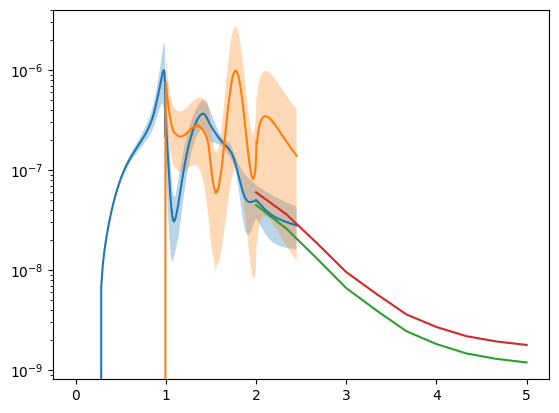

In [117]:
plt.plot(pi_data[:,0],pi_data[:,1])
plt.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
plt.plot(K_data[:,0],K_data[:,1])
plt.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)
plt.plot(m,np.array(br_pi)*res.x[2])
plt.plot(m,np.array(br_K)*res.x[2])
plt.yscale('log')

In [37]:
br_pi,br_K=pi_K_brs(res.x[0],res.x[1])
br_K

np.float64(0.1053172902999189)

In [17]:
from scipy.optimize import fsolve
fsolve(f,[1,1])

array([ 1.96612229, -0.93322628])

In [36]:
SH=ScalarHadronizer(2000,res.x[1],1,1,res.x[0],1,1)
decay_graph=SH.simulateDecay()
SH.print_initial_states(decay_graph)
fs=SH.make_initialMesonPairs()
print('KK br:', fs[(-321,321)]+fs[(-311,311)],K_branching_ratio)
print('pipi br:', fs[(-211,211)]+fs[(111,111)],pi_branching_ratio)

Building decay graph...
Generated 16 initial meson pairs.
Generated decay graph with 161 nodes and 222 edges.
Building weights...
161 of 161 nodes done

Done
The following initial states were generated:
eta eta'(958): 0.17071191058159815
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
eta eta: 0.1375168406657968
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
eta'(958) eta'(958): 0.12280145356425526
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K- K+: 0.10804213897635077
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K~0 K0: 0.10776322262733333
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.06643776790661969
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
K(0)*(700)- K(0)*(700)+: 0.06643776790661969
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
eta eta(1295): 0.05144447217264539
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
pi0 pi0: 0.04026376288692325
	 J: 0.0 0.0, I: 1.0 1.0, C: 1 1, P: -1 -1
pi- pi+: 0.04023789396119862
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: -1 -1
eta eta(1405): 0.02661931900

In [30]:
xx,yy=np.meshgrid(np.linspace(0,5,20),np.linspace(0,2,20))
z=np.array([f([x,y])[0] for x,y in zip(xx.ravel(),yy.ravel())]).reshape(xx.shape)


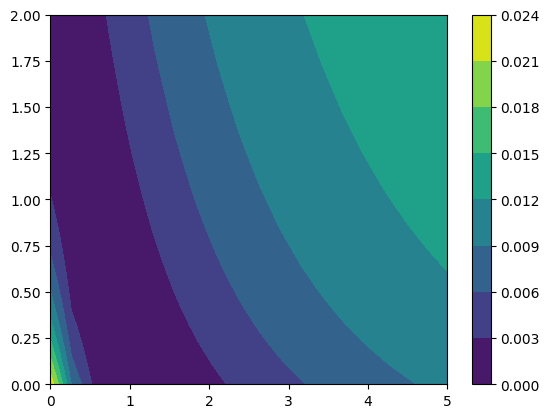

In [31]:
plt.contourf(xx,yy,z**2)
plt.colorbar()

In [112]:
mixed_mesons=p.findall(lambda p: p.invert()==p and ('+' in p.quarks or '-' in p.quarks))
for m in mixed_mesons:
    print(m.name,m.quarks)

pi0 (uU-dD)/sqrt(2)
rho(770)0 (uU-dD)/sqrt(2)
a(2)(1320)0 (uU-dD)/sqrt(2)
rho(3)(1690)0 (uU-dD)/sqrt(2)
a(4)(1970)0 (uU-dD)/sqrt(2)
K(L)0 p(dS)-q(Ds)
eta x(uU+dD)+y(sS)
omega(782) x(uU+dD)+y(sS)
f(2)(1270) x(uU+dD)+y(sS)
omega(3)(1670) x(uU+dD)+y(sS)
f(4)(2050) x(uU+dD)+y(sS)
K(S)0 p(dS)+q(Ds)
eta'(958) x(uU+dD)+y(sS)
phi(1020) x(uU+dD)+y(sS)
f(2)'(1525) x(uU+dD)+y(sS)
phi(3)(1850) x(uU+dD)+y(sS)
a(0)(1450)0 (uU-dD)/sqrt(2)
b(1)(1235)0 (uU-dD)/sqrt(2)
pi(2)(1670)0 (uU-dD)/sqrt(2)
f(0)(1370) x(uU+dD)+y(sS)
h(1)(1170) x(uU+dD)+y(sS)
eta(2)(1645) x(uU+dD)+y(sS)
f(0)(1710) x(uU+dD)+y(sS)
h(1)(1415) x(uU+dD)+y(sS)
eta(2)(1870) x(uU+dD)+y(sS)
a(1)(1260)0 (uU-dD)/sqrt(2)
f(1)(1285) x(uU+dD)+y(sS)
f(1)(1420) x(uU+dD)+y(sS)
rho(1700)0 (uU-dD)/sqrt(2)
omega(1650) x(uU+dD)+y(sS)
pi(1300)0 (uU-dD)/sqrt(2)
rho(1450)0 (uU-dD)/sqrt(2)
eta(1295) x(uU+dD)+y(sS)
omega(1420) x(uU+dD)+y(sS)
eta(1475) x(uU+dD)+y(sS)
phi(1680) x(uU+dD)+y(sS)
a(0)(980)0 Maybe non-qQ
pi(1)(1400)0 Maybe non-qQ
a(2)(1700)0 (uU-

In [111]:
p.findall('pi0')[0].quarks

'(uU-dD)/sqrt(2)'

In [13]:
SH=ScalarHadronizer(2000,0.2,1,1,2,1,1)
eta=p.findall('eta')[0]
eta_p=p.findall('eta')[1]
SH.initialWeight(eta,eta_p,1,1,2,0,0,0.2)

[np.float64(0.42366459261474937), np.float64(0.42366459261474937), np.float64(0.15267081477050132), 0, 0] [np.float64(0.07633540738525066), np.float64(0.07633540738525066), np.float64(0.8473291852294987), 0, 0]
1.1526708147705014 1.8473291852294988
2.129362437087813


np.float64(1371.8450347195705)

array([-0.30224296])

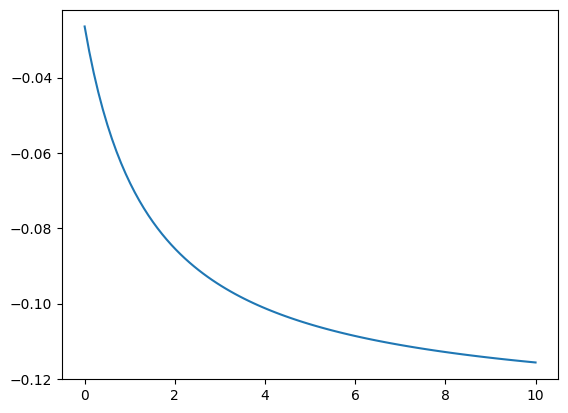

In [22]:
def gamma_pi(ws):
    iw=update_init_weights(SH,meson_pairs,1.5,ws)
    return iw[(-211,211)]+iw[(111,111)]-pi_branching_ratio

x=np.linspace(0,10,100)
plt.plot(x,gamma_pi(x))
optimize.fsolve(gamma_pi,1)

In [15]:
p.findall('K0')

[<Particle: name="K0", pdgid=311, mass=497.611 ± 0.013 MeV>]

In [31]:
def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

ws=K_width_2GeV*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*pi_width_2GeV*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))
ws

np.float64(1.4917312698559564)

In [30]:
def check_result(OAM_supression_par,up_weight,down_weight,strange_weight):
    SH=ScalarHadronizer(2000,OAM_supression_par=OAM_supression_par,up_weight=up_weight,down_weight=down_weight,strange_weight=strange_weight)
    pairs=SH.make_initialMesonPairs()
    print('KK br:', pairs[(-321,321)]+pairs[(-311,311)], 'should be ',K_branching_ratio)
    print('pi pi br:', pairs[(-211,211)]+pairs[(111,111)], 'should be ',pi_branching_ratio)

check_result(-0.3,1,1,1.49)

KK br: 0.29274483246368466 should be  0.3368637986995233
pi pi br: 0.11090426382229096 should be  0.12875788304918576


In [60]:
SH=ScalarHadronizer(2000,0.1,1,1,100,1,1)
SH.print_initial_states()

The following initial states were generated:
eta'(958) eta'(958): 0.5185242065195454
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
eta eta'(958): 0.22057886781478772
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
omega(782) omega(782): 0.11226181735258885
	 J: 1.0 1.0, I: 0.0 0.0, C: -1 -1, P: -1 -1
eta eta: 0.05437390433301063
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K- K+: 0.021767182360818586
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K~0 K0: 0.021710989257923755
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
omega(782) phi(1020): 0.014744349091686752
	 J: 1.0 1.0, I: 0.0 0.0, C: -1 -1, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.013385175667298481
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
K(0)*(700)- K(0)*(700)+: 0.013385175667298481
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
eta f(1)(1420): 0.005563082727038637
	 J: 0.0 1.0, I: 0.0 0.0, C: 1 1, P: -1 1
eta eta(1295): 0.0014584432248505653
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K*(892)- K*(892)+: 0.001133070938462933
	 J: 1.0 1.0, I: 0.5 0.5, C: 

In [33]:
SH.neutral_light_meson_quark_content

{111: [0.5, 0.5, 0, 0, 0],
 221: [np.float64(0.42366459261474937),
  np.float64(0.42366459261474937),
  np.float64(0.15267081477050132),
  0,
  0],
 331: [np.float64(0.07633540738525066),
  np.float64(0.07633540738525066),
  np.float64(0.8473291852294987),
  0,
  0],
 113: [0.5, 0.5, 0, 0, 0],
 333: [np.float64(0.42366459261474937),
  np.float64(0.42366459261474937),
  np.float64(0.15267081477050132),
  0,
  0],
 223: [np.float64(0.07633540738525066),
  np.float64(0.07633540738525066),
  np.float64(0.8473291852294987),
  0,
  0]}

In [39]:
SH=ScalarHadronizer(2000,1,1,1,1.5,0,0)
pairs=SH.make_initialMesonPairs()
eta=pairs[(221,331)]
K=pairs[(-321,321)]
eta/K

np.float64(0.756793414755014)

In [40]:
1/(2+2*0.38+0.75)

0.2849002849002849

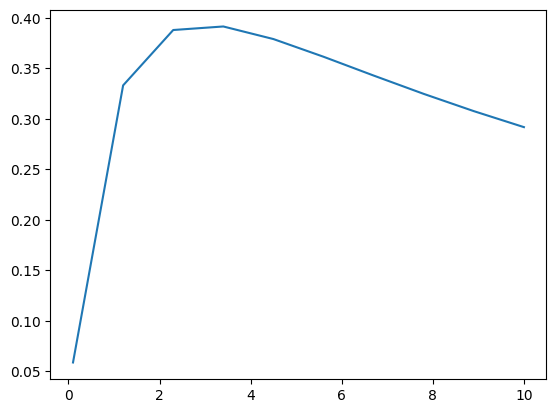

In [105]:
def K_bound(ws,OAM_supression_par):
    SH=ScalarHadronizer(2000,OAM_supression_par=OAM_supression_par,up_weight=1,down_weight=1,strange_weight=ws)
    pairs=SH.make_initialMesonPairs(exclude_below_threshold=False)
    sum=0
    for pair in pairs:
        p1=p.from_pdgid(pair[0])
        p2=p.from_pdgid(pair[1])
        if p1.J==0 and p2.J==0 and not pair in [(-321,321),(-311,311)]:
            sum+=pairs[pair]
    return 1/(1+sum/(pairs[(-321,321)]+pairs[(-311,311)]))

K_bounds=[]
x_range=np.linspace(0.1,10,10)
for x in x_range:
    K_bounds.append(K_bound(x,0.1))
plt.plot(x_range,K_bounds)


In [61]:
e=p.findall('omega')[0].pdgid
print(e)
SH.quark_content(e)

<PDGID: 223>


[np.float64(0.07633540738525066),
 np.float64(0.07633540738525066),
 np.float64(0.8473291852294987),
 0,
 0]

In [130]:
SH=ScalarHadronizer(2000,0.3,1,1,3,0,0)
SH.print_initial_states()

The following initial states were generated:
omega(782) omega(782): 0.2944381850280364
omega(782) phi(1020): 0.09867966920626697
K*(892)- K*(892)+: 0.08847099857569388
K*(892)~0 K*(892)0: 0.0869612380016068
K- K+: 0.06294804984529871
K~0 K0: 0.06278554621100413
eta eta'(958): 0.05467669047056776
eta'(958) eta'(958): 0.05036946463752792
omega(782) h(1)(1170): 0.0387865798866796
eta eta: 0.0343929043147002
rho(770)- rho(770)+: 0.027165910012454456
pi- pi+: 0.015768523797830572
rho(770)0 rho(770)0: 0.013578998072927333
eta f(1)(1420): 0.011728645329925859
eta eta(1295): 0.011388279003524855
eta f(1)(1285): 0.010648375795417837
pi0 pi0: 0.007889330687695663
eta eta(1405): 0.0058927270308411885
pi0 pi(1300)0: 0.004508099538024573
pi0 a(1)(1260)0: 0.004382801675770959
f(0)(980) f(0)(980): 0.0034036538705907653
pi0 pi(2)(1670)0: 0.00329091444344044
a(0)(980)- a(0)(980)+: 0.003168913458946081
pi0 a(1)(1640)0: 0.0020775434040018917
a(0)(980)0 a(0)(980)0: 0.0015844567294730405
pi0 pi(1800)0: 0.0

In [121]:
import scipy.optimize as optimize
m=2449
SH1=ScalarHadronizer(m,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<m and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(m,pi0.mass,pi0.mass)+2*p_restframe(m,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(m,K0.mass,K0.mass)+p_restframe(m,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(gamma_pi,gamma_K,spin_supression):
    ws=strange_weight(gamma_pi,gamma_K)
    pairs=update_init_weights(SH1,meson_pairs,ws,spin_supression)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


def print_result(res,spin_sup=None):
    if len(res.fun)>2:
        print(f'Gamma_pi: {res.x[0]}, rel. dist. to central value: {res.fun[2]}')
        print(f'Gamma_K: {res.x[1]}, rel. dist. to central value: {res.fun[3]}')
    if len(res.fun)>4: print(f'Gamma_tot: {res.x[2]}, rel. dist. to central value: {res.fun[4]}')
    print(f'Cost: {res.cost}')
    print('Parameters:')
    sw=strange_weight(res.x[0],res.x[1])
    print(f'\t strange_weight = {sw}')
    if spin_sup is None: spin_sup=res.x[3]
    print(f'\t spin_supression = {spin_sup}')
    SH=ScalarHadronizer(m,OAM_supression_par=spin_sup,up_weight=1,down_weight=1,strange_weight=sw)
    pairs=SH.make_initialMesonPairs()
    print('Branching ratios:')
    print(f'\t K+K-: {pairs[(-321,321)]}')
    print(f'\t K0K~0-: {pairs[(-311,311)]}')
    print(f'\t pi+pi-: {pairs[(-211,211)]}')
    print(f'\t pi0pi0: {pairs[(111,111)]}')
    #SH.print_initial_states()
    print(f'Check: ')
    BR_K=pairs[(-321,321)]+pairs[(-311,311)]
    BR_pi=pairs[(-211,211)]+pairs[(111,111)]
    print(f'\t Gamma_pi/Gamma_K: {res.x[0]/res.x[1]}, BR(pi)/BR(K): {BR_pi/BR_K}')
    print(f'\t BR(K)*gamma_tot: {BR_K*res.x[2]}, Gamma_K: {res.x[1]}, error: {abs(1-BR_K*res.x[2]/res.x[1])}')
    print(f'\t BR(pi)*gamma_tot: {BR_pi*res.x[2]}, Gamma_pi: {res.x[0]}, error: {abs(1-BR_pi*res.x[2]/res.x[0])}')
    print('\n')
    SH.print_initial_states()

In [125]:
#NLO, fixed spin supression
spin_sup=0.01
def f(x,OAM_supression_par):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,OAM_supression_par)
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central_last/1.2,1-gamma_K/gamma_K_central_last,1-gamma_tot/gamma_tot_central])
res=optimize.least_squares(f,[gamma_pi_central_last,gamma_K_central_last,gamma_tot_central],args=(spin_sup,),bounds=([gamma_pi_lower_last,gamma_K_lower_last,gamma_tot_lower],[gamma_pi_upper_last,gamma_K_upper_last,gamma_tot_upper]))
print(res)
print('\n')
print_result(res,spin_sup)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.736e-01 -1.619e-01  2.640e-01  7.291e-01 -2.937e-01]
           x: [ 2.470e-08  3.777e-08  1.979e-07]
        cost: 0.37193865541990284
         jac: [[-2.420e+07 -1.675e+07  5.516e+06]
               [-2.396e+07 -1.658e+07  5.461e+06]
               ...
               [ 0.000e+00 -7.172e+06  0.000e+00]
               [ 0.000e+00  0.000e+00 -6.538e+06]]
        grad: [ 2.166e+05  3.635e+05  7.821e+04]
  optimality: 0.009217523308283633
 active_mask: [-1  0  0]
        nfev: 19
        njev: 17


Gamma_pi: 2.4704764810958535e-08, rel. dist. to central value: 0.2640041952524925
Gamma_K: 3.7772848404330874e-08, rel. dist. to central value: 0.7290934967420686
Gamma_tot: 1.9785543651957947e-07, rel. dist. to central value: -0.2936714155596363
Cost: 0.37193865541990284
Parameters:
	 strange_weight = 0.8307060736874232
	 spin_supression = 0.01
Branching ratios:
	 K+K-: 0.0825689776052

In [126]:
#NNLO
import scipy.optimize as optimize
spin_sup=0.1
def f(x,OAM_supression_par):
    gamma_pi=x[0]
    gamma_K=x[1]
    gamma_tot=x[2]
    br_pi,br_K=pi_K_brs_2GeV(gamma_pi,gamma_K,OAM_supression_par)
    return np.array([1-gamma_pi/(br_pi*gamma_tot), 1-gamma_K/(br_K*gamma_tot),1-gamma_pi/gamma_pi_central/1.2,1-gamma_K/gamma_K_central,1-gamma_tot/gamma_tot_NNLO_central])
res=optimize.least_squares(f,[gamma_pi_central,gamma_K_central,gamma_tot_NNLO_central],args=(spin_sup,),bounds=([gamma_pi_lower,gamma_K_lower,gamma_tot_NNLO_lower],[gamma_pi_upper,gamma_K_upper,gamma_tot_NNLO_upper]))
print(res)
print('\n')
print_result(res,spin_sup)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.966e-01 -1.847e-01  4.494e-01  7.868e-01 -3.272e-01]
           x: [ 3.309e-08  2.794e-08  3.292e-07]
        cost: 0.5003985670702602
         jac: [[-2.376e+07 -1.584e+07  3.478e+06]
               [-2.352e+07 -1.568e+07  3.443e+06]
               ...
               [ 0.000e+00 -7.632e+06  0.000e+00]
               [ 0.000e+00  0.000e+00 -4.032e+06]]
        grad: [ 1.539e+06  5.588e+03 -6.785e+02]
  optimality: 0.00012521996260995318
 active_mask: [-1  0  0]
        nfev: 19
        njev: 10


Gamma_pi: 3.308844602118522e-08, rel. dist. to central value: 0.44942718797983316
Gamma_K: 2.793988086476692e-08, rel. dist. to central value: 0.7867624557737649
Gamma_tot: 3.291694554059138e-07, rel. dist. to central value: -0.3271711373821591
Cost: 0.5003985670702602
Parameters:
	 strange_weight = 0.45877162882904066
	 spin_supression = 0.1
Branching ratios:
	 K+K-: 0.035851861036158

In [128]:
strange_weight(gamma_pi_lower,gamma_K_central_last)

np.float64(2.289504699543579)

# Chi square fit


In [7]:
import scipy.optimize as optimize
SH1=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(ws,wv):
    pairs=update_init_weights(SH1,meson_pairs,ws,wv)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


In [ ]:
def chi2(x):
    ws=x[0]
    wv=x[1]
    gamma_tot=x[2]
    sigma_pi=(gamma_pi_upper-gamma_pi_lower)/2
    sigma_K=(gamma_K_upper-gamma_K_lower)/4
    sigma_gamma=(gamma_tot_NNLO_upper-gamma_tot_NNLO_lower)/2
    br_pi,br_K=pi_K_brs_2GeV(ws,wv)

    return (br_pi*gamma_tot-gamma_pi_central)**2/sigma_pi**2+(br_K*gamma_tot-gamma_K_central)**2/sigma_K**2+(gamma_tot-gamma_tot_NNLO_central)**2/sigma_gamma**2

In [70]:
def chi2(x):
    ws=x[0]
    wv=x[1]
    gamma_tot=x[2]
    sigma_pi1=(gamma_pi_upper-gamma_pi_central)
    sigma_pi2=gamma_pi_central-gamma_pi_lower
    sigma_K1=(gamma_K_upper-gamma_K_central)
    sigma_K2=gamma_K_central-gamma_K_lower
    sigma_gamma1=(gamma_tot_upper-gamma_tot_central)
    sigma_gamma2=gamma_tot_central-gamma_tot_lower
    br_pi,br_K=pi_K_brs_2GeV(ws,wv)
    if br_pi*gamma_tot>gamma_pi_central: sigma_pi=sigma_pi1
    else: sigma_pi=sigma_pi2
    if br_K*gamma_tot>gamma_K_central: sigma_K=sigma_K1
    else: sigma_K=sigma_K2
    if gamma_tot>gamma_tot_central: sigma_gamma=sigma_gamma1
    else: sigma_gamma=sigma_gamma2

    return (br_pi*gamma_tot-gamma_pi_central)**2/sigma_pi**2+(br_K*gamma_tot-gamma_K_central)**2/sigma_K**2+(gamma_tot-gamma_tot_NNLO_central)**2/sigma_gamma**2

In [71]:
res=optimize.minimize(chi2,(1,1,gamma_tot_central),method='Nelder-Mead',bounds=[(0,np.inf),(0,np.inf),(0,np.inf)])

In [72]:
print(res.message)
print(f'chi2: {res.fun}')
print(f'Parameters:')
print(f'\t ws: {res.x[0]}')
print(f'\t wv: {res.x[1]} ')
print(f'\t gamma_tot: {res.x[2]}, distance to central value: {1-res.x[2]/gamma_tot_central}')
print('resulting decay widths:')
br_pi,br_K=pi_K_brs_2GeV(res.x[0],res.x[1])
print(f'br_pi: {br_pi}, gamma_pi: {br_pi*res.x[2]}, distrance to central value: {1-br_pi*res.x[2]/gamma_pi_central}')
print(f'br_K: {br_K}, gamma_K: {br_K*res.x[2]}, distrance to central value: {1-br_K*res.x[2]/gamma_K_central}')
print(f'')

Optimization terminated successfully.
chi2: 0.12843702423652856
Parameters:
	 ws: 1.1622672928012086
	 wv: 1.401552188576781e-09 
	 gamma_tot: 3.0853529013348953e-07, distance to central value: -1.0173480828139687
resulting decay widths:
br_pi: 0.15995040852192538, gamma_pi: 4.935034570028242e-08, distrance to central value: 0.014606176827693274
br_K: 0.32934122464017845, gamma_K: 1.0161339029727622e-07, distrance to central value: 0.224485247007016



In [73]:
X,Y=np.meshgrid(np.linspace(0,2,50),np.linspace(0,1,50))
Z=np.vectorize(lambda x,y: chi2([x,y,res.x[2]]))(X,Y)

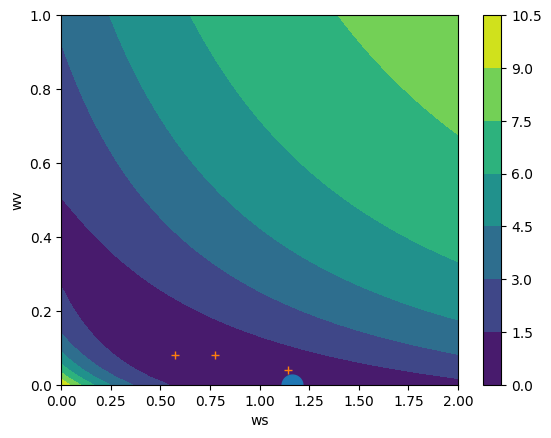

In [74]:
plt.contourf(X,Y,Z)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')

plt.plot(res.x[0],res.x[1],'o',markersize=15)
mask=np.abs(Z-0.5)<8e-3
plt.plot(X[mask],Y[mask],'+')

In [150]:
chi2([0,0.4,res.x[2]])

np.float64(0.1677254509812301)

In [151]:
0.15*res.x[2]

np.float64(4.1168942741230906e-08)

In [146]:
SH=ScalarHadronizer(2000,0.4,1,1,0,0,0)
SH.print_initial_states()

The following initial states were generated:
rho(770)- rho(770)+: 0.24020654919615916
rho(770)0 rho(770)0: 0.12006828658210916
pi- pi+: 0.10457139165385651
eta eta: 0.09610514867048622
eta f(1)(1285): 0.06111839385954586
pi0 pi0: 0.052319310279591
eta eta(1295): 0.049023907605186774
pi0 a(1)(1260)0: 0.03875363151337211
omega(782) phi(1020): 0.032089914393465827
pi0 pi(1300)0: 0.029896155686443823
pi0 pi(2)(1670)0: 0.02909894061329863
eta eta(1405): 0.025366827192513514
f(0)(980) f(0)(980): 0.022571854316805456
a(0)(980)- a(0)(980)+: 0.021015137160665515
omega(782) h(1)(1170): 0.019430965600666282
pi0 a(1)(1640)0: 0.018370064969358557
eta eta'(958): 0.013335348081054762
a(0)(980)0 a(0)(980)0: 0.010507568580332758
omega(782) omega(782): 0.008357171971373947
pi0 pi(1800)0: 0.006721187627799988
eta'(958) eta'(958): 0.0010722444459142849


In [130]:
print((gamma_pi_upper+gamma_pi_lower)/2)
print((gamma_pi_upper-gamma_pi_lower))

5.183657025657252e-08
3.749765515321874e-08


In [87]:
a=np.arange(0,5)
np.where(a<2,1,0)

array([1, 1, 0, 0, 0])

In [88]:
a

array([0, 1, 2, 3, 4])

In [159]:
print(abs(gamma_K_upper-gamma_K_central),abs(gamma_K_central-gamma_K_lower))

2.4765902674646827e-07 1.1923775958886718e-07


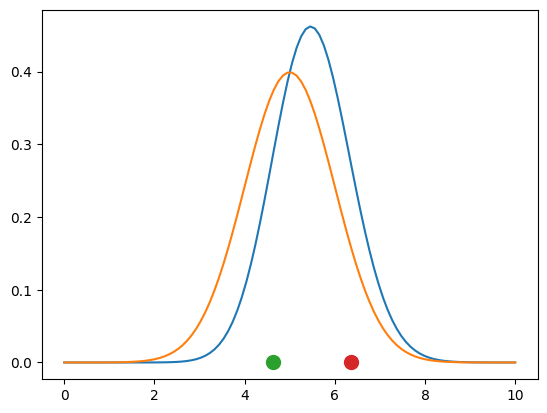

In [8]:
from scipy.stats import skewnorm,norm
x=np.linspace(0,10,100)
xi=5
alpha=0.8
omega=1
plt.plot(x,skewnorm.pdf(x,alpha,loc=xi,scale=omega))
plt.plot(x,norm.pdf(x,loc=xi))
p1=skewnorm.ppf(0.16,alpha,loc=xi,scale=omega)
p2=skewnorm.ppf(0.84,alpha,loc=xi,scale=omega)
plt.plot(p1,0,'o',markersize=10)
plt.plot(p2,0,'o',markersize=10)

In [9]:
def fit_skewnorm(x,scaling=1):
    loc=x[0]
    scale=x[1]
    skew=x[2]
    mean=skewnorm.mean(skew,loc=loc,scale=scale)
    median=skewnorm.median(skew,loc=loc,scale=scale)
    return [skewnorm.cdf(gamma_pi_lower*scaling,skew,loc=loc,scale=scale)-0.16,skewnorm.cdf(gamma_pi_upper*scaling,skew,loc=loc,scale=scale)-0.84,median-gamma_pi_central*scaling]

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 9.577e-11 -1.332e-10  4.904e-11]
           x: [ 4.378e+00  1.041e+00  1.332e+00]
        cost: 1.4660893626010036e-20
         jac: [[-3.867e-02  3.975e-02 -2.652e-02]
               [-2.779e-02 -7.157e-02 -1.159e-05]
               [ 1.000e+00  6.053e-01  1.369e-01]]
        grad: [ 4.904e-11  4.303e-11  4.177e-12]
  optimality: 4.903904632747108e-11
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 9
        njev: 8
0.2852381953741676
0.17353078237537667


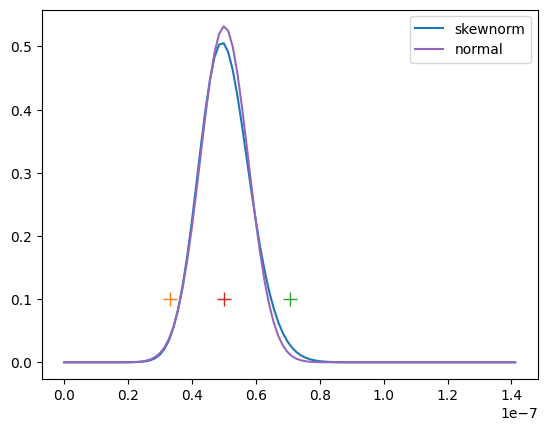

In [10]:
from scipy import optimize
from scipy.stats import skewnorm,norm
def fit_skewnorm_pi(x,scaling=1):
    loc=x[0]
    scale=x[1]
    skew=x[2]
    mean=skewnorm.mean(skew,loc=loc,scale=scale)
    median=skewnorm.median(skew,loc=loc,scale=scale)
    return [skewnorm.cdf(gamma_pi_lower*scaling,skew,loc=loc,scale=scale)-0.01,skewnorm.cdf(gamma_pi_upper*scaling,skew,loc=loc,scale=scale)-0.99,median-gamma_pi_central*scaling]

scaling=1e8
res=optimize.least_squares(fit_skewnorm_pi,x0=(1,1,0),args=(scaling,))
print(res)
x=np.linspace(0,gamma_pi_upper*2,100)
plt.plot(x,skewnorm.pdf(scaling*x,res.x[2],loc=res.x[0],scale=res.x[1]),label='skewnorm')
plt.plot(gamma_pi_lower,0.1,'+',markersize=10)
plt.plot(gamma_pi_upper,0.1,'+',markersize=10)
plt.plot(gamma_pi_central,0.1,'+',markersize=10)

plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_pi_central,scale=(gamma_pi_upper-gamma_pi_lower)/5),label='normal')
plt.legend()
print(abs(1-skewnorm.ppf(0.16,res.x[2],loc=res.x[0],scale=res.x[1])/gamma_pi_lower*1e-8))
print(abs(1-skewnorm.ppf(0.84,res.x[2],loc=res.x[0],scale=res.x[1])/gamma_pi_upper*1e-8))

     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [-9.808e-03  5.588e-03 -1.234e-03]
           x: [ 3.196e+00  4.427e+00]
        cost: 6.446996196525358e-05
         jac: [[-2.485e-04 -5.014e-04]
               [-1.206e-02 -5.306e-03]
               [ 4.099e+00  3.193e+00]]
        grad: [-5.122e-03 -3.964e-03]
  optimality: 0.18063195613521632
 active_mask: [0 0]
        nfev: 200
        njev: 150
2.332039609392891
0.17865059512638826


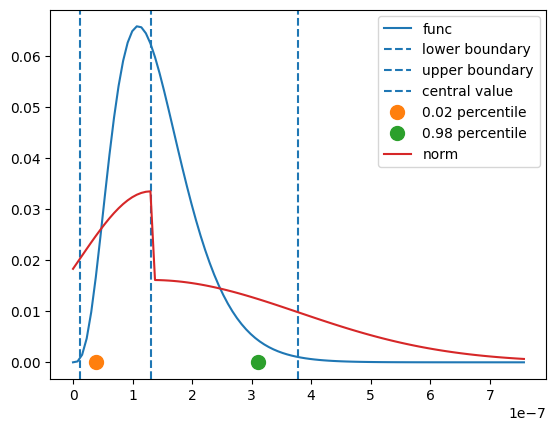

In [11]:
from scipy.stats import gamma,chi
def fit_func_K(x,scaling=1,func=gamma):
    #loc=x[0]
    scale=x[0]
    skew=x[1]
    #loc=x[2]
    loc=0
    mean=func.mean(skew,loc=loc,scale=scale)
    median=func.median(skew,loc=loc,scale=scale)
    return [func.cdf(gamma_K_lower*scaling,skew,loc=loc,scale=scale)-0.01,func.cdf(gamma_K_upper*scaling,skew,loc=loc,scale=scale)-0.99,median-gamma_K_central*scaling]

def fit_gamma_K2(x,scaling=1):
    loc=0
    scale=x[0]
    skew=x[1]
    median=gamma.median(skew,loc=loc,scale=scale)
    mean=func.mean(skew,loc=loc,scale=scale)
    return mean-gamma_K_central*scaling
scaling=1e8
func=gamma
#res_K=optimize.least_squares(fit_func_K,x0=(0,1,1),args=(scaling,),bounds=([0,0,0],[np.inf,np.inf,50]))
res_K=optimize.least_squares(fit_func_K,x0=(1,1),args=(scaling,),bounds=([0,0],[np.inf,50]))
#res_K=optimize.least_squares(fit_gamma_K2,x0=(1,1),args=(scaling,),bounds=([1,0],[50,np.inf]))
print(res_K)
if len(res_K.x)<3: loc=0
else: loc=res_K.x[2]
x=np.linspace(0,gamma_K_upper*2,100)
plt.plot(x,func.pdf(scaling*x,res_K.x[1],loc=loc,scale=res_K.x[0]),label='func')
plt.axvline(gamma_K_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_K_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_K_central,linestyle='--',label='central value')
plt.plot(func.ppf(0.02,res_K.x[1],loc=loc,scale=res_K.x[0])/scaling,0,'o',markersize=10,label='0.02 percentile')
plt.plot(func.ppf(0.98,res_K.x[1],loc=loc,scale=res_K.x[0])/scaling,0,'o',markersize=10,label='0.98 percentile')
#plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_K_central,scale=(gamma_K_upper-gamma_K_lower)/4),label='norm')
plt.plot(x,1/scaling*np.where(x<gamma_K_central,norm.pdf(x,loc=gamma_K_central,scale=gamma_K_central-gamma_K_lower),norm.pdf(x,loc=gamma_K_central,scale=gamma_K_upper-gamma_K_central)),label='norm')
plt.legend()
#plt.xscale('log')
print(abs(1-func.ppf(0.02,res_K.x[1],loc=loc,scale=res_K.x[0])/gamma_K_lower*1e-8))
print(abs(1-func.ppf(0.98,res_K.x[1],loc=loc,scale=res_K.x[0])/gamma_K_upper*1e-8))


     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.041e-17  0.000e+00 -1.776e-15]
           x: [ 6.317e+00  1.501e+00  7.817e+00]
        cost: 1.5777759772217095e-30
         jac: [[-4.577e-03 -6.197e-02 -4.946e-02]
               [-1.424e-02 -3.482e-02 -2.895e-03]
               [ 1.184e+00  6.236e+00  1.000e+00]]
        grad: [-2.102e-15 -1.108e-14 -1.776e-15]
  optimality: 1.1077078451091316e-14
 active_mask: [0 0 0]
        nfev: 31
        njev: 23
0.6369866978266174
0.4212045467826073


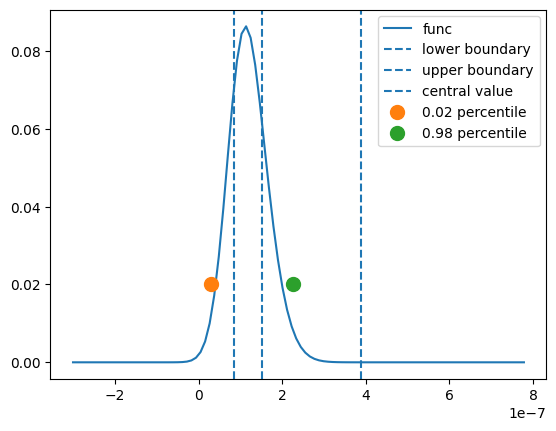

In [12]:
from scipy.stats import gamma,chi2,chi
def fit_func_gamma_tot(x,scaling=1,func=gamma):
    loc=x[2]
    scale=x[0]
    skew=x[1]
    mean=func.mean(skew,loc=loc,scale=scale)
    median=func.median(skew,loc=loc,scale=scale)
    return [func.cdf(gamma_tot_lower*scaling,skew,loc=loc,scale=scale)-0.02,func.cdf(gamma_tot_upper*scaling,skew,loc=loc,scale=scale)-0.98,median-gamma_tot_central*scaling]

scaling=1e8
func=skewnorm
#res_gamma=optimize.least_squares(fit_func_gamma_tot,x0=(1,1),args=(scaling,),bounds=([0,0],[np.inf,50]))
res_gamma=optimize.least_squares(fit_func_gamma_tot,x0=(1,1,0),args=(scaling,),bounds=([0,0,0],[np.inf,np.inf,np.inf]))
print(res_gamma)
if len(res_gamma.x)<3: loc=0
else: loc=res_gamma.x[2]
x=np.linspace(-3e-7,gamma_tot_upper*2,100)
plt.plot(x,func.pdf(scaling*x,res_gamma.x[1],loc=loc,scale=res_gamma.x[0]),label='func')
plt.axvline(gamma_tot_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_tot_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_tot_central,linestyle='--',label='central value')
plt.plot(func.ppf(0.02,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/scaling,0.02,'o',markersize=10,label='0.02 percentile')
plt.plot(func.ppf(0.98,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/scaling,0.02,'o',markersize=10,label='0.98 percentile')


#plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_tot_central,scale=(gamma_tot_upper-gamma_tot_lower)/2),label='norm')
plt.legend()
print(abs(1-func.ppf(0.02,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/gamma_tot_lower*1e-8))
print(abs(1-func.ppf(0.98,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/gamma_tot_upper*1e-8))

In [100]:
def nll(theta,mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot):
    ws=theta[0]
    wv=theta[1]
    gamma_tot=theta[2]
    br_pi,br_K=pi_K_brs_2GeV(ws,wv)
    gamma_pi=br_pi*gamma_tot
    gamma_K=br_K*gamma_tot
    scaling=1e8
    return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot

mu_pi=gamma_pi_central*scaling
sigma_pi=(gamma_pi_upper-gamma_pi_lower)/5*scaling
a_K=res_K.x[1]
omega_K=res_K.x[0]
a_tot=res_gamma.x[1]
omega_tot=res_gamma.x[0]

nll([1,0.2,gamma_tot_central],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)

np.float64(358.0814395207578)

In [250]:
res_nll=optimize.minimize(nll,(1,0.2,gamma_tot_central*scaling),args=(mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot),bounds=[(0,10),(0,1),(0,gamma_tot_upper*2*scaling)],method='Nelder-Mead')
ws_min=res_nll.x[0]
wv_min=res_nll.x[1]
gamma_tot_min=res_nll.x[2]/scaling
res_nll

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -31.35810968373024
             x: [ 5.310e-01  0.000e+00  1.944e+01]
           nit: 117
          nfev: 204
 final_simplex: (array([[ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01]]), array([-3.136e+01, -3.136e+01, -3.136e+01, -3.136e+01]))

In [194]:
print(res_nll.message)
print(f'L: {res_nll.fun}')
print(f'Parameters:')
print(f'\t ws: {res_nll.x[0]}')
print(f'\t wv: {res_nll.x[1]} ')
print(f'\t gamma_tot: {res_nll.x[2]/scaling}, distance to central value: {1-res_nll.x[2]/scaling/gamma_tot_central}')
print('resulting decay widths:')
br_pi,br_K=pi_K_brs_2GeV(res_nll.x[0],res_nll.x[1])
print(f'br_pi: {br_pi}, gamma_pi: {br_pi*res_nll.x[2]/scaling}, distrance to central value: {1-br_pi*res_nll.x[2]/scaling/gamma_pi_central}')
print(f'br_K: {br_K}, gamma_K: {br_K*res_nll.x[2]/scaling}, distrance to central value: {1-br_K*res_nll.x[2]/scaling/gamma_K_central}')
print(f'')

Optimization terminated successfully.
L: -31.35810968373024
Parameters:
	 ws: 0.5309985875301801
	 wv: 0.0 
	 gamma_tot: 1.9440276023265107e-07, distance to central value: -0.27109620257509026
resulting decay widths:
br_pi: 0.2354134771980641, gamma_pi: 4.5765029763269924e-08, distrance to central value: 0.08619530408345488
br_K: 0.22145190159419254, gamma_K: 4.305086092868045e-08, distrance to central value: 0.6714352539407804



/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


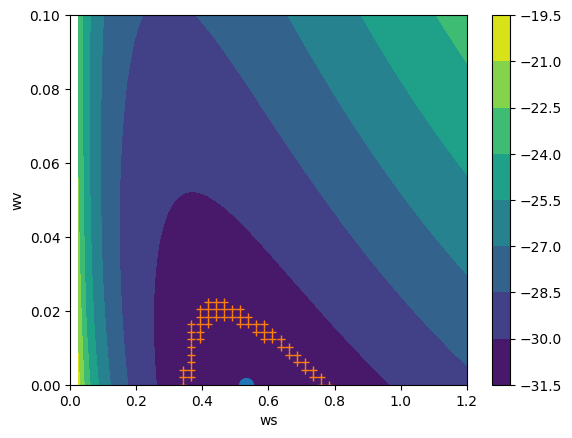

In [170]:
ws=np.linspace(0,1.2,50)
wv=np.linspace(0,0.1,50)
gamma_tot=np.linspace(0,gamma_tot_upper*2,50)
X,Y=np.meshgrid(ws,wv)
nll_const_gamma=np.vectorize(lambda x,y: nll([x,y,res_nll.x[2]],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot))(X,Y)
plt.contourf(X,Y,nll_const_gamma)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
mask=np.abs(nll_const_gamma-0.5-res_nll.fun)<8e-2
plt.plot(X[mask],Y[mask],'+')

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


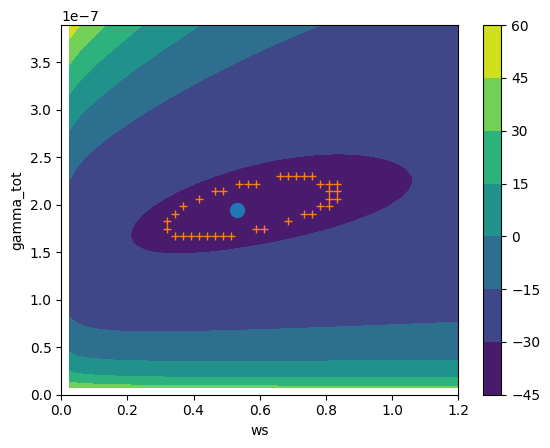

In [197]:
ws=np.linspace(0,1.2,50)
wv=np.linspace(0,0.1,50)
gamma_tot=np.linspace(0,gamma_tot_upper,50)
X,Y=np.meshgrid(ws,gamma_tot)
nll_const_wv=np.vectorize(lambda x,y: nll([x,res_nll.x[1],y*scaling],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot))(X,Y)
plt.contourf(X,Y,nll_const_wv)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('gamma_tot')
plt.plot(res_nll.x[0],res_nll.x[2]/scaling,'o',markersize=10)
mask=np.abs(nll_const_wv-0.5-res_nll.fun)<8e-2
plt.plot(X[mask],Y[mask],'+')

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


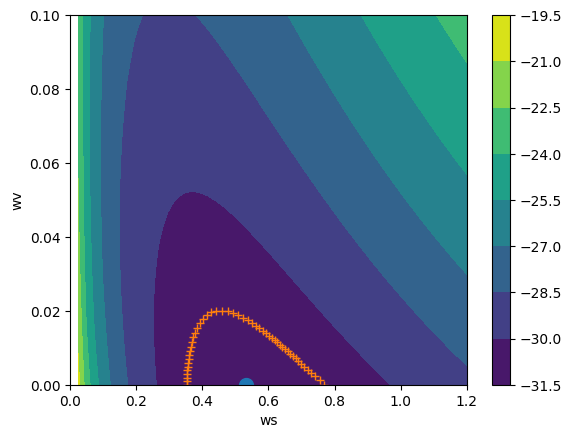

In [ ]:
ws_contour=[]
wv_contour=[]
for phi in np.linspace(0,np.pi,40):
    aspect_ratio=0.1/1.2
    root=optimize.root_scalar(lambda r: nll([r*np.cos(phi)+res_nll.x[0],(r*np.sin(phi)+res_nll.x[1])*aspect_ratio,res_nll.x[2]],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)-res_nll.fun-0.5,bracket=[0,np.sqrt(res_nll.x[0]**2+res_nll.x[1]**2)])
    ws_contour.append(root.root*np.cos(phi)+res_nll.x[0])
    wv_contour.append((root.root*np.sin(phi)+res_nll.x[1])*aspect_ratio)


plt.contourf(X,Y,Z)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
plt.plot(ws_contour,wv_contour,'+')


-3.141592653589793 0.53099858753018
-3.0133643820146996 0.4031214258456741
-2.885136110439606 0.2773440036206729
-2.7569078388645125 0.15573158265080675
-2.628679567289419 0.04028103552625017
-2.500451295714325 0.5309985875301816
-2.3722230241392315 0.530998587530183
-2.243994752564138 0.5309985875301853
-2.1157664809890444 0.5309985875301885
-1.9875382094139509 0.5309985875301928
-1.8593099378388573 0.5309985875301984
-1.7310816662637636 0.5309985875302053
-1.60285339468867 0.5309985875302136
-1.4746251231135765 0.5309985875302229
-1.3463968515384828 0.5309985875302333
-1.2181685799633892 0.5309985875302445
-1.0899403083882957 0.5309985875302563
-0.9617120368132022 0.5309985875302682
-0.8334837652381086 0.5309985875302797
-0.7052554936630151 0.5309985875302905
-0.5770272220879216 0.5309985875303004
-0.4487989505128276 0.09711484841332516
-0.32057067893773405 0.21589036950689194
-0.19234240736264052 0.339839958829026
-0.06411413578754699 0.4669283675496286
0.06411413578754654 0.5950688

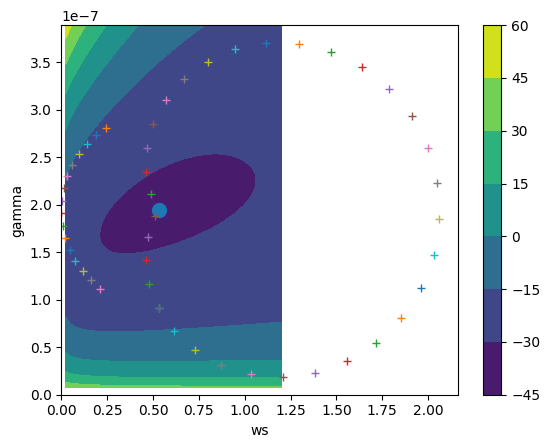

In [281]:
ws_list=[]
wv_list=[]
for phi in np.linspace(0,np.pi,50):
    aspect_ratio=gamma_tot_upper/1.2*scaling
    R=np.sqrt(ws**2+(gamma_tot_min)**2)
    ws=1*np.cos(phi)+ws_min
    gamma=(gamma_tot_upper*np.sin(phi)+gamma_tot_min)
    ws_list.append(ws)
    wv_list.append(gamma)

def get_upper_bound(theta,phi):
    vec=param_vec(1,theta,phi)
    return np.linalg.norm([np.where(vec[0]<0,ws_min,vec[0]),np.where(vec[1]<0,wv_min,vec[1]),np.where(vec[2]<0,gamma_tot_min,vec[2])])

def param_vec(r,theta,phi):
    ws=r*np.sin(theta)*np.cos(phi)+ws_min
    wv=0.1*r*np.sin(theta)*np.sin(phi)+wv_min
    gamma_tot=gamma_tot_min*r*np.cos(theta)+gamma_tot_min
    return np.array([ws,wv,gamma_tot])
theta=np.linspace(-np.pi,np.pi,50)
phi=np.linspace(0,np.pi,50)
theta_grid,phi_grid=np.meshgrid(theta,phi)
upper_bound=upper_bound_vec(theta_grid,phi_grid)
upper_bound=param_vec(1,theta_grid,phi_grid)

plt.contourf(X,Y,nll_const_wv)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('gamma')
plt.plot(ws_min,gamma_tot_min,'o',markersize=10)
#plt.plot(ws_list,wv_list,'+')
#plt.plot(upper_bound[0,phi_grid==0],upper_bound[2,phi_grid==0],'+')
for theta in np.linspace(-np.pi,np.pi,50):
    upper_bound=get_upper_bound(theta,0)
    print(theta,upper_bound)
    #upper_bound=1
    plt.plot(param_vec(upper_bound,theta,0)[0],param_vec(upper_bound,theta,0)[2],'+')

print(param_vec(1,-np.pi/2,0))
print(get_upper_bound(-np.pi/2,0))


In [272]:
for theta in np.linspace(-np.pi,np.pi,50):
    for phi in np.linspace(0,np.pi,50):
        upper_bound=get_upper_bound(theta,phi)
        root=optimize.root_scalar(lambda r: nll(param_vec(r,theta,phi),mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)-res_nll.fun-0.5,bracket=[0,upper_bound])
        

ValueError: f(a) and f(b) must have different signs

In [158]:
from scipy.interpolate import CubicSpline
interpolation = CubicSpline(ws_contour, wv_contour)
plt.contourf(X,Y,Z)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
plt.plot(ws_contour,interpolation(ws_contour))

ValueError: `x` must be strictly increasing sequence.

In [22]:
import scipy.optimize as optimize
SH1=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(ws,wv):
    pairs=update_init_weights(SH1,meson_pairs,ws,wv)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


# model likelihoods
based on https://arxiv.org/abs/2411.15499v1

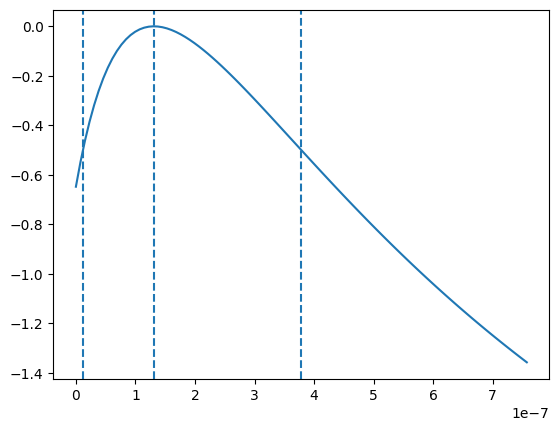

In [46]:
# K
def logL_model(a,central,upper,lower):
    sigp=upper-central
    sigm=central-lower
    sigma1=2*sigp*sigm/(sigp+sigm)
    sigma2=(sigp-sigm)/(sigp+sigm)
    return -0.5*(a-central)**2/(sigma1+(a-central)*sigma2)**2

x=np.linspace(0,gamma_K_upper*2,100)
plt.plot(x,logL_model(x,gamma_K_central,gamma_K_upper,gamma_K_lower))
plt.axvline(gamma_K_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_K_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_K_central,linestyle='--',label='central value')


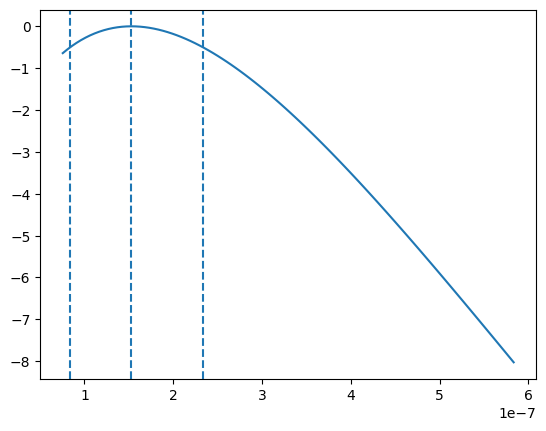

In [ ]:
#gamma
x=np.linspace(gamma_tot_lower*0.9,gamma_tot_upper*1.5,100)
plt.plot(x,logL_model(x,gamma_tot_central,gamma_tot_upper,gamma_tot_lower))
plt.axvline(gamma_tot_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_tot_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_tot_central,linestyle='--',label='central value')

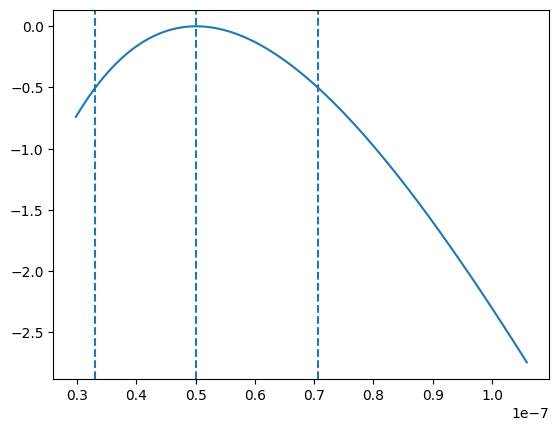

In [19]:
#pi
x=np.linspace(gamma_pi_lower*0.9,gamma_pi_upper*1.5,100)
plt.plot(x,logL_model(x,gamma_pi_central,gamma_pi_upper,gamma_pi_lower))
plt.axvline(gamma_pi_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_pi_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_pi_central,linestyle='--',label='central value')


# analysis with scipy

In [56]:
from scipy import optimize
def nll2(theta):
    ws=theta[0]
    wv=theta[1]
    gamma_tot=theta[2]
    br_pi,br_K=pi_K_brs_2GeV(ws,wv)
    gamma_pi=br_pi*gamma_tot
    gamma_K=br_K*gamma_tot
    return -logL_model(gamma_pi,gamma_pi_central,gamma_pi_upper,gamma_pi_lower)-logL_model(gamma_K,gamma_K_central,gamma_K_upper,gamma_K_lower)-logL_model(gamma_tot,gamma_tot_central,gamma_tot_upper,gamma_tot_lower)


res_nll2=optimize.minimize(nll2,(1,0.5,gamma_tot_central),bounds=[(0,10),(0,1),(0,gamma_tot_upper*2)],method='Nelder-Mead')
ws_min=res_nll2.x[0]
wv_min=res_nll2.x[1]
gamma_tot_min=res_nll2.x[2]
res_nll2

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.2745165541659939
             x: [ 7.265e-01  0.000e+00  2.320e-07]
           nit: 82
          nfev: 148
 final_simplex: (array([[ 7.265e-01,  0.000e+00,  2.320e-07],
                       [ 7.265e-01,  0.000e+00,  2.320e-07],
                       [ 7.264e-01,  0.000e+00,  2.320e-07],
                       [ 7.265e-01,  0.000e+00,  2.320e-07]]), array([ 2.745e-01,  2.745e-01,  2.745e-01,  2.745e-01]))

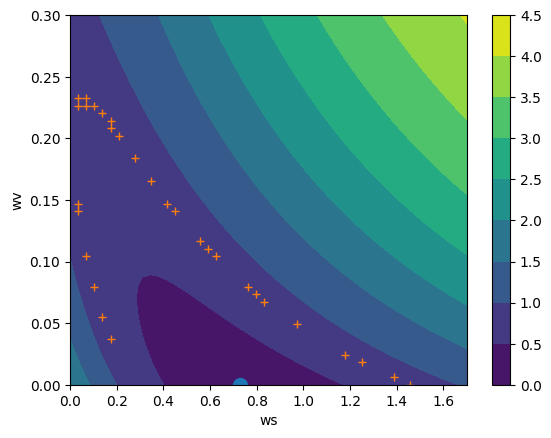

In [57]:
ws=np.linspace(0,1.7,50)
wv=np.linspace(0,0.3,50)
gamma_tot=np.linspace(0,gamma_tot_upper*2,50)
X,Y=np.meshgrid(ws,wv)
nll_const_gamma=np.vectorize(lambda x,y: nll2([x,y,res_nll2.x[2]]))(X,Y)
plt.contourf(X,Y,nll_const_gamma)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll2.x[0],res_nll2.x[1],'o',markersize=10)
mask=np.abs(nll_const_gamma-0.5-res_nll2.fun)<1e-2
plt.plot(X[mask],Y[mask],'+')

In [41]:
ws_contour=[]
wv_contour=[]
for phi in np.sort(np.concatenate((np.linspace(0,np.pi,40),np.linspace(np.pi/2,3*np.pi/4,40)))):
    aspect_ratio=0.1/1.2
    upper_bound=np.sqrt(ws_min**2+wv_min**2)
    root=optimize.root_scalar(lambda r: nll2([r*np.cos(phi)+ws_min,(r*np.sin(phi)+wv_min)*aspect_ratio,gamma_tot_min])-res_nll2.fun-0.5,x0=upper_bound)
    ws_contour.append(root.root*np.cos(phi)+ws_min)
    wv_contour.append((root.root*np.sin(phi)+wv_min)*aspect_ratio)

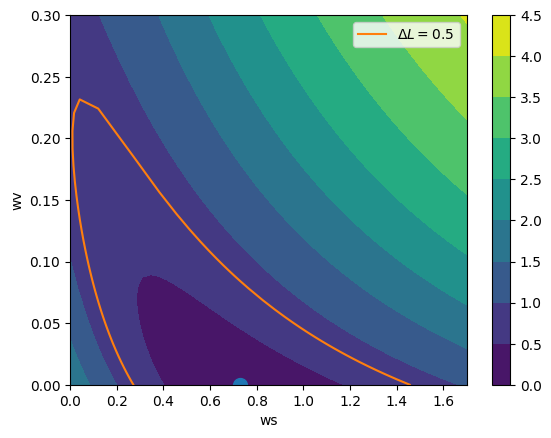

In [43]:
plt.contourf(X,Y,nll_const_gamma)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(ws_min,wv_min,'o',markersize=10)
plt.plot(ws_contour,wv_contour,label=r'$\Delta L=0.5$')
plt.legend()

In [57]:
SH_best_fit=ScalarHadronizer(2000,wv_min,1,1,ws_min,0,0)
SH_best_fit.print_initial_states()

The following initial states were generated:
eta eta: 0.16180943802871675
pi- pi+: 0.13766380585501442
K- K+: 0.1330864269920723
K~0 K0: 0.13274285752304754
eta eta'(958): 0.09990627186515921
eta eta(1295): 0.07298606751735447
pi0 pi0: 0.06887615493001095
pi0 pi(1300)0: 0.03935702209886491
eta eta(1405): 0.03776575659949988
eta'(958) eta'(958): 0.03574484385538873
f(0)(980) f(0)(980): 0.02971488971612801
a(0)(980)- a(0)(980)+: 0.027665537546622713
a(0)(980)0 a(0)(980)0: 0.013832768773311356
pi0 pi(1800)0: 0.008848158698808513


In [64]:
def pi_K_brs_vec(m_array,ws,wv):
    br_pi=[]
    br_K=[]
    for m in m_array:
        SH=ScalarHadronizer(m*1e3,wv,1,1,ws,1,0)
        pairs=SH.make_initialMesonPairs()
        br_pi.append(pairs[(-211,211)]+pairs[(111,111)])
        br_K.append(pairs[(-321,321)]+pairs[(-311,311)])
    return br_pi,br_K


m=np.linspace(2,3.6,10)
br_pi,br_K=pi_K_brs_vec(m,ws_min,wv_min)

In [25]:
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'stogg'))
if module_path not in sys.path:
    sys.path.append(module_path)

from decay_to_gluons import gg_NLO,mqHIGLU

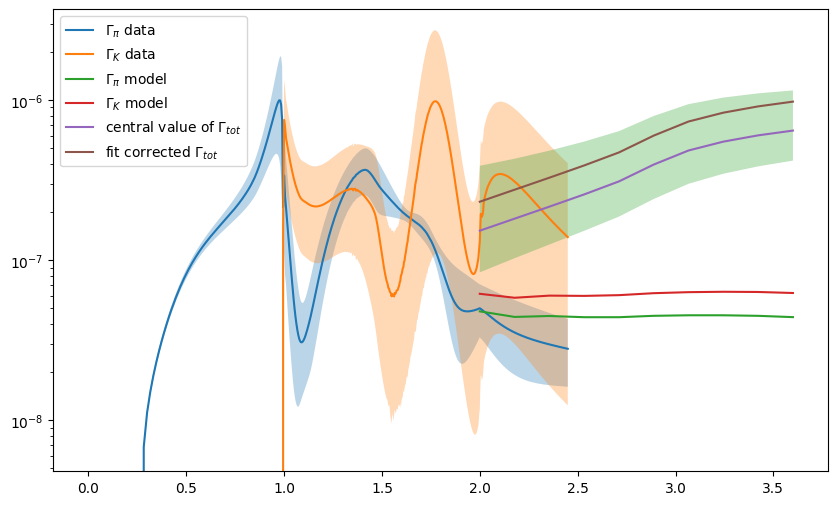

In [65]:
fig,ax=plt.subplots(figsize=(10,6))

gamma_tot=gamma_tot_min/gamma_tot_central*gg_NLO(m,m,mqHIGLU,fixed_NF=3)
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)
ax.plot(m,np.array(br_pi)*gamma_tot,label=r'$\Gamma_\pi$ model')
ax.plot(m,np.array(br_K)*gamma_tot,label=r'$\Gamma_K$ model')

ax.plot(m,gg_NLO(m,m,mqHIGLU,fixed_NF=3),label=r'central value of $\Gamma_{tot}$')
ax.fill_between(m, gg_NLO(m,m/2,mqHIGLU,fixed_NF=3),gg_NLO(m,m*2,mqHIGLU,fixed_NF=3),alpha=0.3,interpolate=True)
ax.plot(m,gamma_tot_min/gamma_tot_central*gg_NLO(m,m,mqHIGLU,fixed_NF=3),label=r'fit corrected $\Gamma_{tot}$')
ax.set_yscale('log')
ax.legend()

# analysis with iminuit

In [ ]:
from iminuit import Minuit

def nll_minuit(ws,wv,gamma_tot):
    br_pi,br_K=pi_K_brs_2GeV(ws,wv)
    gamma_pi=br_pi*gamma_tot
    gamma_K=br_K*gamma_tot
    return -logL_model(gamma_pi,gamma_pi_central,gamma_pi_upper,gamma_pi_lower)-logL_model(gamma_K,gamma_K_central,gamma_K_upper,gamma_K_lower)-logL_model(gamma_tot,gamma_tot_central,gamma_tot_upper,gamma_tot_lower)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_tot=gamma_tot_central)
m.limits=[(0,10),(0,1),(0,gamma_tot_upper*2)]
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
m.minos()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.2745                     │              Nfcn = 601              │
│ EDM = 1.5e-05 (Goal: 0.0001)     │            time = 5.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │    0.7    │    1.1    │    -0.7    │    1.7     │    0    │   10    │       │
│ 1 │ wv        │  0.11e-6  │175220.20e-6│  -0.11e-6  │258714.29e-6│    0    │    1    │       │
│ 2 │ gamma_tot │  0.23e-6  │  0.16e-6  │  -0.11e-6  │  0.34e-6   │    0    │7.77923e-07│       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ws           │          wv           │       gamma_tot       │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.7    │    1.7    │ -0.11e-6  │258714.29e-6│ -0.11e-6  │  0.34e-6  │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────────────────┐
│           │            ws            wv     gamma_tot │
├───────────┼───────────────────────────────────────────┤
│        ws │          1.25      -0.27e-6 160.830073e-9 │
│        wv │      -0.27e-6      8.04e-08     0.036e-12 │
│ gamma_tot │ 160.830073e-9     0.036e-12      2.78e-14 │
└───────────┴───────────────────────────────────────────┘

In [151]:
ws_opt=m.params[0].value
wv_opt=m.params[1].value
gamma_tot_opt=m.params[2].value
cov_matrix=np.array(m.covariance)

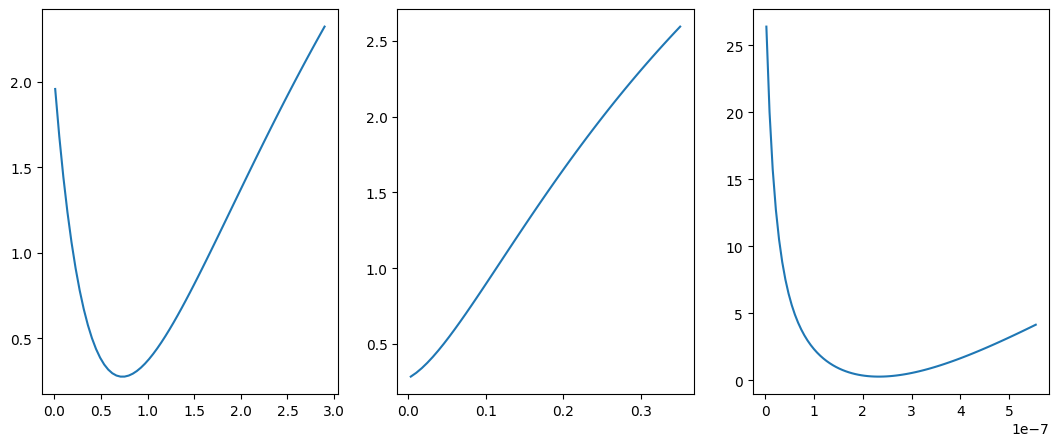

In [ ]:
#likelihood profiles
fig,axis=plt.subplots(1,3,figsize=(13,5))
for i,a in enumerate(['ws','wv','gamma_tot']):
    x,y=m.profile(a)
    axis[i].plot(x[x>0],y[x>0])

0.19874804309879915


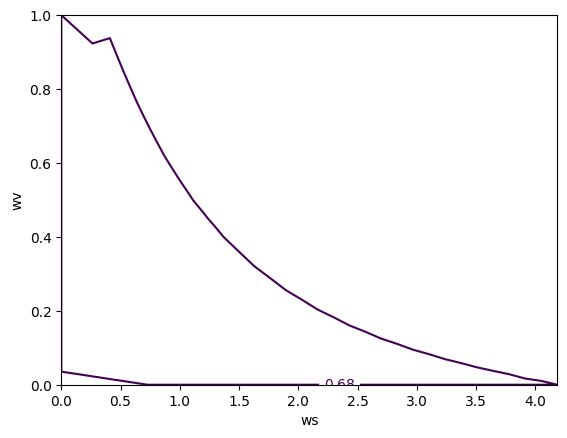

In [69]:
from scipy.stats import chi2
cl=chi2.cdf(1,3)
print(cl)
m.draw_mncontour('ws','wv',cl=0.68)

(array([-1.43282746, -1.34445069, -1.25607392, -1.16769715, -1.07932039,
        -0.99094362, -0.90256685, -0.81419008, -0.72581331, -0.63743654,
        -0.54905977, -0.460683  , -0.37230623, -0.28392946, -0.19555269,
        -0.10717592, -0.01879916,  0.06957761,  0.15795438,  0.24633115,
         0.33470792,  0.42308469,  0.51146146,  0.59983823,  0.688215  ,
         0.77659177,  0.86496854,  0.9533453 ,  1.04172207,  1.13009884,
         1.21847561,  1.30685238,  1.39522915,  1.48360592,  1.57198269,
         1.66035946,  1.74873623,  1.837113  ,  1.92548977,  2.01386653,
         2.1022433 ,  2.19062007,  2.27899684,  2.36737361,  2.45575038,
         2.54412715,  2.63250392,  2.72088069,  2.80925746,  2.89763423]),
 array([-0.35044029, -0.3361366 , -0.32183291, -0.30752922, -0.29322553,
        -0.27892184, -0.26461815, -0.25031447, -0.23601078, -0.22170709,
        -0.2074034 , -0.19309971, -0.17879602, -0.16449233, -0.15018864,
        -0.13588495, -0.12158126, -0.10727757, -0

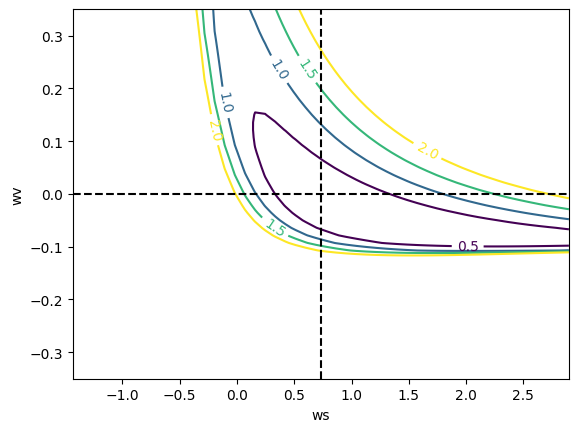

In [57]:
m.draw_contour('ws','wv')

(<Figure size 640x480 with 9 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='wv'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='ws', ylabel='gamma_tot'>, <Axes: xlabel='wv'>,
         <Axes: xlabel='gamma_tot'>]], dtype=object))

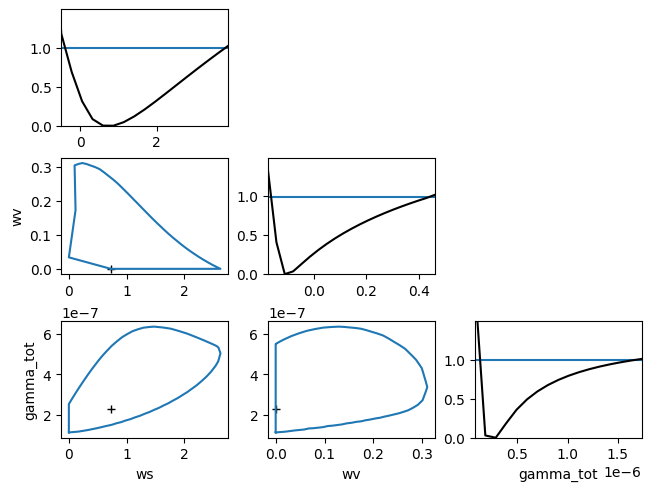

In [62]:
m.draw_mnmatrix()

In [68]:
chi2.cdf(1,3)

np.float64(0.19874804309879915)

# compute errors

In [212]:
import networkx as nx

def sample_positive_multivariate_normal(mean, cov, size=1):
    samples = []
    while len(samples) < size:
        sample = np.random.multivariate_normal(mean, cov)
        if np.all(sample > 0):
            samples.append(sample)
    return np.array(samples)

def compute_errors(m):
    sampled_pars = sample_positive_multivariate_normal([ws_opt,wv_opt,gamma_tot_opt], cov_matrix, 200)
    SH_sampled=ScalarHadronizer(m,1,1,1,1,1,0)
    decay_graph_init,_=SH_sampled.build_decay_graph(exclude_below_threshold=False)
    print(decay_graph_init)
    fs_keys= [s for s,d in decay_graph_init.out_degree() if d==0]
    final_state_sample = {key: [] for key in fs_keys}
    for ws_sample,wv_sample,gamma_sample in sampled_pars:
        SH_sampled.set_parameters(wv_sample,1,1,ws_sample,1,0)
        new_initial_states=SH_sampled.make_initialMesonPairs(exclude_below_threshold=False)
        reweighted_graph=SH_sampled.buildWeights(decay_graph_init,new_initial_states,fs_keys)
        final_states= [s for s,d in reweighted_graph.out_degree() if d==0]
        attributes=nx.get_node_attributes(reweighted_graph,'weight')
        for key in fs_keys:
            final_state_sample[key].append(attributes[key])
    fs_mean_var={s:(np.mean(v),np.std(v)) for s,v in final_state_sample.items()}
    return fs_mean_var,decay_graph_init
brs_with_errors,dg=compute_errors(2000)

Generated 26 initial meson pairs.
DiGraph with 264 nodes and 418 edges


In [215]:
#check if mean values are close to the central values
from math import isclose
SH=ScalarHadronizer(2000,wv_opt,1,1,ws_min,1,0)
decay_graph=SH.simulateDecay()
fs=SH.get_final_states(decay_graph)
print(len(fs))
for key in fs:
    if not isclose(fs[key],brs_with_errors[key][0],rel_tol=0.3):
        print(fs[key],brs_with_errors[key])


Generated 14 initial meson pairs.
109
0.006214027403851676 (np.float64(0.009110349288783782), np.float64(0.004531132200930024))
0.00310723470669268 (np.float64(0.004549630341435459), np.float64(0.002256602643072666))
0.0069314251858691505 (np.float64(0.01014383582591834), np.float64(0.005024765751585914))
0.0025744755633930446 (np.float64(0.003769565906308493), np.float64(0.0018696926917044214))
0.003589838414783385 (np.float64(0.005249435150882713), np.float64(0.0025951100686326047))
0.0005294910440815535 (np.float64(0.0008640908037932822), np.float64(0.0005248678242645912))
0.00028297440381116345 (np.float64(0.0004636494578207108), np.float64(0.00028304468248735155))
0.004601946151203435 (np.float64(0.007167895357653086), np.float64(0.004089688436437661))
0.0010791653483032326 (np.float64(0.0018789068733913873), np.float64(0.001231252950193543))
0.0030612098514438647 (np.float64(0.005329793288688081), np.float64(0.0034926285083912052))
0.0012856022624080019 (np.float64(0.002238328844

In [216]:
fs_in_degree= {s:d for s,d in dg.in_degree() if dg.out_degree(s)==0}

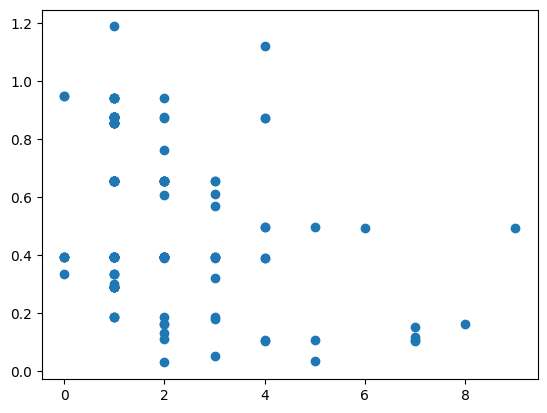

In [217]:
x=[d for s,d in fs_in_degree.items()]
y=[brs_with_errors[s][1]/brs_with_errors[s][0] for s in fs_in_degree]
plt.scatter(x,y)

In [221]:
sorted_keys = sorted(brs_with_errors.keys(), key=lambda k: brs_with_errors[k][1])
for key in sorted_keys:
    print(key,brs_with_errors[key][0],brs_with_errors[key][1])


(-211, 22, 111, 111, 111, 130, 211) 2.9105054631004333e-08 2.7381853573700497e-08
(-211, -211, 22, 111, 130, 211, 211) 6.573529255539377e-08 6.184335257899652e-08
(111, 111, 111, 111, 111, 111, 130) 2.0607644115908937e-07 1.9387542845552722e-07
(22, 22, 111, 111, 111, 130) 2.487216733793001e-07 2.339957965178623e-07
(-211, -211, 111, 111, 130, 211, 211) 3.2496098971949007e-07 3.0572126905356103e-07
(-211, 22, 22, 111, 130, 211) 5.617509457288107e-07 5.284917804087724e-07
(-211, 22, 111, 111, 111, 111, 211) 6.200268408613051e-07 5.30717268247127e-07
(-211, 111, 111, 111, 111, 130, 211) 6.093146567039594e-07 5.732394225573622e-07
(-211, -211, 22, 111, 111, 211, 211) 9.868715651997468e-07 7.516537552124026e-07
(-211, -211, -211, 111, 211, 211, 211) 1.3692840197200217e-06 1.1958020375582704e-06
(22, 111, 111, 111, 130) 1.4057858906363566e-06 1.2032944357416494e-06
(111, 111, 111, 111, 130) 2.5319705711886937e-06 2.2148334068367764e-06
(-211, 22, 111, 130, 211) 3.17504117284101e-06 2.717703

Generated 14 initial meson pairs.


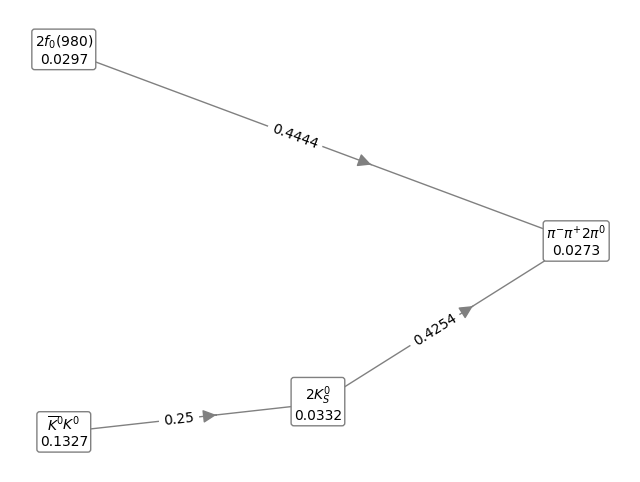

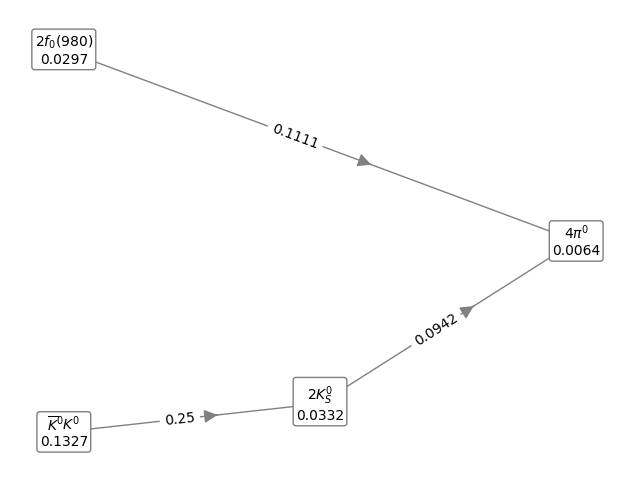

In [234]:
SH=ScalarHadronizer(2000,wv_opt,1,1,ws_min,1,0)
decay_graph=SH.simulateDecay()
fs=SH.get_final_states(decay_graph)
SH.plot_from_final_state(decay_graph,(-211,111,111,211))
SH.plot_from_final_state(decay_graph,(111,111,111,111))


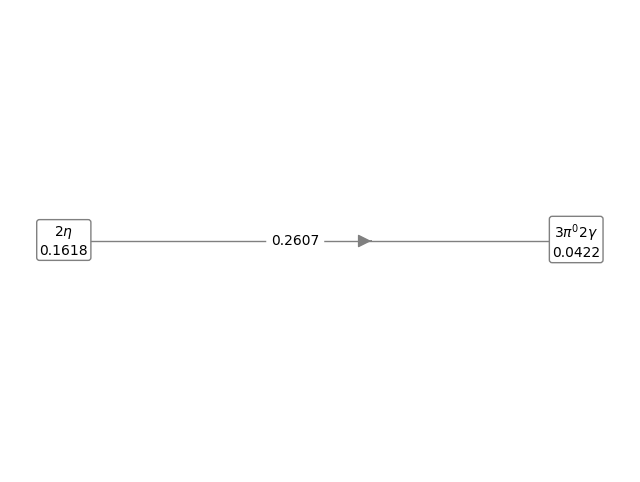

In [242]:
SH.plot_from_final_state(decay_graph,(22,22,111,111,111))

In [233]:
SH.print_final_states(20,decay_graph)

The following final states were generated:
(-211, 211) pi- pi+ :		 0.13766380585501445
(-321, 321) K- K+ :		 0.13308642699207232
(111, 111) pi0 pi0 :		 0.06887615493001097
(-211, 130, 211) pi- K(L)0 pi+ :		 0.04600305056226082
(22, 22, 111, 111, 111) gamma gamma pi0 pi0 pi0 :		 0.042178456156019804
(111, 100111) pi0 pi(1300)0 :		 0.039357022098864915
(130, 130) K(L)0 K(L)0 :		 0.03318571438076189
(-211, 22, 22, 111, 211) pi- gamma gamma pi0 pi+ :		 0.02944851375461745
(-211, -211, 211, 211) pi- pi- pi+ pi+ :		 0.029150646681315184
(22, 22, 100221) gamma gamma eta(1295) :		 0.028916370833573925
(-211, 111, 111, 211) pi- pi0 pi0 pi+ :		 0.027323591147115536
(22, 22, 22, 22) gamma gamma gamma gamma :		 0.025453409755805012
(-211, 111, 111, 111, 111, 211) pi- pi0 pi0 pi0 pi0 pi+ :		 0.024399340956191562
(-211, 22, 22, 111, 111, 111, 211) pi- gamma gamma pi0 pi0 pi0 pi+ :		 0.02414322821195188
(111, 111, 111, 100221) pi0 pi0 pi0 eta(1295) :		 0.02395843800685583
(111, 111, 130) pi0 pi0 K(L)

In [235]:
SH.print_initial_states()

The following initial states were generated:
eta eta: 0.16180943802871678
pi- pi+: 0.13766380585501445
K- K+: 0.13308642699207232
K~0 K0: 0.13274285752304757
eta eta'(958): 0.09990627186515925
eta eta(1295): 0.07298606751735448
pi0 pi0: 0.06887615493001097
pi0 pi(1300)0: 0.039357022098864915
eta eta(1405): 0.037765756599499885
eta'(958) eta'(958): 0.035744843855388744
f(0)(980) f(0)(980): 0.029714889716128016
a(0)(980)- a(0)(980)+: 0.02766553754662272
a(0)(980)0 a(0)(980)0: 0.01383276877331136
pi0 pi(1800)0: 0.008848158698808515


In [224]:
brs_with_errors[(-211,111,111,211)]

(np.float64(0.027044862793316585), np.float64(0.0009719103519564667))

In [241]:
pid=p.from_pdgid(9000311)
print(pid)
SH.single_particle_decays(int(pid.pdgid))

K(0)*(700)0


{}

In [244]:
m=np.linspace(2,5,10)
all_brs=[]
for mass in m*1e3:
    brs_with_errors,dg=compute_errors(mass)
    all_brs.append(brs_with_errors)


Generated 26 initial meson pairs.
DiGraph with 264 nodes and 418 edges


KeyboardInterrupt: 